In [1]:
import pandas as pd
import numpy as np
df_train_filtered = pd.read_pickle('./data/df_train_filtered.pkl')


In [2]:
from sklearn.model_selection import train_test_split

X = df_train_filtered.drop('Hinta', axis=1)
y = df_train_filtered['Hinta']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=df_train_filtered['Kaupunginosa'], random_state=42)





In [7]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler 

# Skaalataan numeeriset muuttujat
robust_scaler = RobustScaler()
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
df_train_NN = df_train_filtered.copy()
df_train_NN[['Pituusaste', 'Leveysaste']] = minmax_scaler.fit_transform(df_train_NN[['Pituusaste', 'Leveysaste']])
df_train_NN['Rv'] = minmax_scaler.fit_transform(df_train_NN[['Rv']])
df_train_NN['m2'] = minmax_scaler.fit_transform(df_train_NN[['m2']])

# One hot koodataan kategoriset muuttujat
df_hot = pd.get_dummies(df_train_NN['Kaupunginosa'], prefix='Kaupunginosa').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['kerros'], prefix='kerros').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['max_kerros'], prefix='max_kerros').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['Kunto'], prefix='Kunto').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['Hissi'], prefix='Hissi').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN['Asunnon tyyppi'], prefix='Asunnon tyyppi').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)

df_hot = pd.get_dummies(df_train_NN["Talot."], prefix='Talot.').astype('int')
df_train_NN = pd.concat([df_train_NN, df_hot], axis=1)


df_train_NN.drop(['Kaupunginosa', 'kerros', 'max_kerros', 'Kunto', 'Hissi', 'Asunnon tyyppi', "Talot."], axis=1, inplace=True)




In [8]:
# Muodostetaan X ja y sekä jaetaan data harjoitus- ja testijoukkoihin

X = df_train_NN.drop('Hinta', axis=1)
y = df_train_NN['Hinta']

X = X.to_numpy()
y = y.to_numpy().astype('float32')

X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X, y, test_size=0.1, random_state=42, stratify=df_train_filtered['Kaupunginosa'])

In [9]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras import regularizers, layers, optimizers, initializers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import time 
from optuna.integration import TFKerasPruningCallback
import os 
import pickle 
from datetime import timedelta


# Haun nimi
study_name = 'rmsle5_random_2503'
# Montako osittelua käytettiin
folds = 5
# Montako epochia kullekin osittelulle
epochs_search = 100
# Montako satunnaista hakua kieroksella
num_random = 42
# Montako TPE hakua kieroksella
num_tpe = 0

# Aika sekuntteina jota hakuun käytetän
max_search_time = 36000
# Neuroneiden maksimimäärä 
max_units = 512

def rmsle_loss(y_true, y_pred):
    # Asetetaan suuri rangaistusarvo, jos y_pred sisältää arvon nolla tai alle
    penalty = tf.constant(1e5, dtype=tf.float32)
    
    # Maski, joka on tosi, kun y_pred on > 0
    valid_mask = tf.math.greater(y_pred, 0.0)
    
    # Käytä maskia valitsemaan joko oikea RMSLE laskenta tai suuri rangaistus
    safe_y_pred = tf.where(valid_mask, y_pred, penalty)
    
    # Laske RMSLE vain, jos y_pred on suurempi kuin 0, muuten palauta rangaistus
    rmsle = tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(safe_y_pred) - tf.math.log1p(y_true))))
    
    # Palauta suuri rangaistus, jos y_pred sisälsi nollan tai negatiivisen arvon
    return tf.where(tf.reduce_any(~valid_mask), penalty, rmsle)


def create_model(trial):
        
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(X_train_NN.shape[1],)))
    
    num_units = trial.suggest_int(f'n_units_0', 4, 512, log=True)
    dropout_rate = trial.suggest_float(f'dropout_0', 0.0, 0.5)
    kernel_regularizer=regularizers.l1_l2(
            l1= trial.suggest_float(f'l1_reg_0', 1e-6, 1, log=True),
            l2= trial.suggest_float(f'l2_reg_0', 1e-6, 1, log=True)
        )
    activation = trial.suggest_categorical(f'activation_0', ['relu', 'tanh', 'selu', 'linear', 'sigmoid', 'elu'])    
    model.add(keras.layers.Dense(num_units, activation=activation, kernel_regularizer=kernel_regularizer))    
    model.add(keras.layers.Dropout(rate=dropout_rate))

    num_units = trial.suggest_int(f'n_units_1', 4, 256, log=True)
    dropout_rate = trial.suggest_float(f'dropout_1', 0.0, 0.5)
    kernel_regularizer=regularizers.l1_l2(
            l1= trial.suggest_float(f'l1_reg_1', 1e-6, 1, log=True),
            l2= trial.suggest_float(f'l2_reg_1', 1e-6, 1, log=True)
        )
    activation = trial.suggest_categorical(f'activation_1', ['relu', 'tanh', 'selu', 'linear', 'sigmoid', 'elu'])    
    model.add(keras.layers.Dense(num_units, activation=activation, kernel_regularizer=kernel_regularizer))    
    model.add(keras.layers.Dropout(rate=dropout_rate))
    
    num_last = trial.suggest_int('n_units_last', 1, 32)
    dropout_last = trial.suggest_float('dropout_last', 0.0, 0.5)
    activation_last = trial.suggest_categorical('activation_last', ['relu', 'tanh', 'selu', 'linear', 'sigmoid', 'elu'])
    kernel_regularizer_last = regularizers.l1_l2( 
        l1= trial.suggest_float('l1_reg_last', 1e-6, 1, log=True),
        l2= trial.suggest_float('l2_reg_last', 1e-6, 1, log=True)
    )
    model.add(keras.layers.Dense(num_last, activation=activation_last, kernel_regularizer=kernel_regularizer_last))        
    model.add(keras.layers.Dropout(rate=dropout_last))
    model.add(keras.layers.Dense(1, activation='linear')) 
    
    # Optimisaattorin ja oppimisnopeuden valinta
    optimizer_options = ['adam', 'rmsprop', 'Nadam', 'adamax', 'Adagrad', 'Adadelta']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    learning_rate = trial.suggest_float('lr', 1e-4, 1.0, log=True)
    
    if optimizer_selected == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_selected == 'rmsprop':
        optimizer = optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_selected == 'Nadam':
        optimizer = optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer_selected == 'Adagrad':
        optimizer = optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_selected == 'Adadelta':
        optimizer = optimizers.Adadelta(learning_rate=learning_rate)
    else:
        optimizer = optimizers.Adamax(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=rmsle_loss, metrics=['mse', 'mae'])
    
    return model

def objective(trial):

    model = create_model(trial)
    batch_size = trial.suggest_int('batch_size', 16, 128, log=True)    
    callbacks = [TFKerasPruningCallback(trial, 'val_loss'),
                 ReduceLROnPlateau('val_loss', patience=5, factor=0.7), 
                 TerminateOnNaN()]

    history = model.fit(X_train_b, y_train_b, epochs=epochs_search, validation_data=(X_val_b, y_val_b) ,batch_size=batch_size, verbose=0, callbacks=callbacks)
    val_loss = np.min(history.history['val_loss'])
    
    return val_loss


####

total_time_start = time.time()  
search_time_start = time.time() 
num_completed_trials = 0
search_rounds = 0
time_taken = 0
while time_taken < max_search_time:
        
    fold = 0 
    kf = KFold(n_splits=folds)
    
    time_fold_start = time.time()    
    for train_index, val_index in kf.split(X_train_NN):

        print('-------------------')
        print(f"Starting fold {fold} search...")
        X_train_b, X_val_b = X_train_NN[train_index], X_train_NN[val_index]    
        y_train_b, y_val_b = y_train_NN[train_index], y_train_NN[val_index]

        fold_name = f'{study_name}_{fold}'
       
        study = optuna.create_study(direction='minimize',
                                    pruner=optuna.pruners.HyperbandPruner(min_resource=5),
                                    study_name=fold_name,
                                    storage=f'sqlite:///tampere_reg.db',
                                    load_if_exists=True                                 
                                    )

        fold_time = time.time()    

        fold_random = time.time()
        # # study.sampler = optuna.samplers.RandomSampler()
        study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False) # TODO tämä testiin, vaikutti paljon paremmalta kuin random 
        print(f'Random search for fold {fold}...')
        study.optimize(objective, n_trials=num_random)
        print(f'Time taken for random search: {str(timedelta(seconds=(time.time() - fold_random)))}')

        # fold_tpe = time.time()  
        # study.sampler = optuna.samplers.TPESampler(n_startup_trials=0)
        # print(f'TPE search for fold {fold}...')
        # study.optimize(objective, n_trials=num_tpe)
        # print(f'Time taken for TPE search: {str(timedelta(seconds=(time.time() - fold_tpe)))}')

        num_completed_trials += num_random + num_tpe
        print('-------------------')
        print(f'Finished fold {fold} search.')
        print(f"Time taken for this fold: {str(timedelta(seconds=(time.time() - fold_time)))}")                
        print(f'Fold {fold} best value so far: {study.best_value}')
        print(f'Mean time for one trial this fold: {str(timedelta(seconds=(time.time() - fold_time) / (num_random + num_tpe)))}')

        fold += 1
    search_rounds += 1
    
    time_taken = time.time() - search_time_start
    
    print(f'\n# Completed search round: {search_rounds} #')
    print(f'Time taken for all folds this round: {str(timedelta(seconds=(time.time() - time_fold_start)))}')
    print(f'Total time taken for search: {str(timedelta(seconds=(time.time() - search_time_start)))}')
    print(f'Made trials this far: {num_completed_trials}')
    print(f"Current mean time for one trial: {str(timedelta(seconds=(time.time() - search_time_start) / num_completed_trials))}\n")

####

####

# num_tpe = 42
    # num_random = 0
    # max_search_time = 7200
    
# while time_taken < max_search_time:
        
#     fold = 0 
#     kf = KFold(n_splits=folds)
    
#     time_fold_start = time.time()    
#     for train_index, val_index in kf.split(X_train_NN):

#         print('-------------------')
#         print(f"Starting fold {fold} search...")
#         X_train_b, X_val_b = X_train_NN[train_index], X_train_NN[val_index]    
#         y_train_b, y_val_b = y_train_NN[train_index], y_train_NN[val_index]

#         fold_name = f'{study_name}_{fold}'
       
#         study = optuna.create_study(direction='minimize',
#                                     pruner=optuna.pruners.HyperbandPruner(min_resource=20),
#                                     study_name=fold_name,
#                                     storage=f'sqlite:///tampere_reg.db',
#                                     load_if_exists=True                                 
#                                     )

#         fold_time = time.time()    

#         # fold_random = time.time()
#         # study.sampler = optuna.samplers.RandomSampler()
#         # print(f'Random search for fold {fold}...')
#         # study.optimize(objective, n_trials=num_random)
#         # print(f'Time taken for random search: {str(timedelta(seconds=(time.time() - fold_random)))}')

#         fold_tpe = time.time()  
#         study.sampler = optuna.samplers.TPESampler(n_startup_trials=0)
#         print(f'TPE search for fold {fold}...')
#         study.optimize(objective, n_trials=num_tpe)
#         print(f'Time taken for TPE search: {str(timedelta(seconds=(time.time() - fold_tpe)))}')

#         num_completed_trials += num_random + num_tpe
#         print('-------------------')
#         print(f'Finished fold {fold} search.')
#         print(f"Time taken for this fold: {str(timedelta(seconds=(time.time() - fold_time)))}")                
#         print(f'Fold {fold} best value so far: {study.best_value}')
#         print(f'Mean time for one trial this fold: {str(timedelta(seconds=(time.time() - fold_time) / (num_random + num_tpe)))}')

#         fold += 1
#     search_rounds += 1
    
#     time_taken = time.time() - search_time_start
    
#     print(f'\n# Completed search round: {search_rounds} #')
#     print(f'Time taken for all folds this round: {str(timedelta(seconds=(time.time() - time_fold_start)))}')
#     print(f'Total time taken for search: {str(timedelta(seconds=(time.time() - search_time_start)))}')
#     print(f'Made trials this far: {num_completed_trials}')
#     print(f"Current mean time for one trial: {str(timedelta(seconds=(time.time() - search_time_start) / num_completed_trials))}\n")

###

print('='*20)    
print(f'Finished search.')    
print(f'Total time taken for all folds: {str(timedelta(seconds=(time.time() - search_time_start)))}')
print(f'Made {num_completed_trials} trials in total.')
print(f"Mean time for one trial: {str(timedelta(seconds=(time.time() - search_time_start) / num_completed_trials))}")
print('='*20)







2024-03-26 00:08:19.576698: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 00:08:20.102721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[I 2024-03-26 00:08:20,647] Using an existing study with name 'rmsle5_random_2503_0' instead of creating a new one.


-------------------
Starting fold 0 search...
Random search for fold 0...


/tmp/ipykernel_744092/3223606834.py:154: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False) # TODO tämä testiin, vaikutti paljon paremmalta kuin random
2024-03-26 00:08:21.317748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-26 00:08:21.334271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-26 00:08:21.334334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA s

Time taken for random search: 0:05:43.943441
-------------------
Finished fold 0 search.
Time taken for this fold: 0:05:43.943513
Fold 0 best value so far: 0.2443513721227646
Mean time for one trial this fold: 0:00:08.189296
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 00:14:12,851] Trial 336 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:14:14,670] Trial 337 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:14:17,106] Trial 338 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:14:24,530] Trial 339 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 00:14:26,860] Trial 340 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:14:29,931] Trial 341 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:14:31,398] Trial 342 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:14:36,349] Trial 343 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:14:38,546] Trial 344 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:14:42,853] Trial 345 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:14:44,434] Trial 346 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:14:47,065] Trial 347 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:14:49,151] Trial 348 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:14:

Time taken for random search: 0:04:50.910597
-------------------
Finished fold 1 search.
Time taken for this fold: 0:04:50.910659
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:06.926615
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 00:19:03,291] Trial 336 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:19:07,111] Trial 337 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:19:09,432] Trial 338 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:19:18,879] Trial 339 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 00:19:22,167] Trial 340 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:19:28,721] Trial 341 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:19:29,962] Trial 342 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:19:32,872] Trial 343 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:19:34,118] Trial 344 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:19:49,075] Trial 345 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 00:19:57,184] Trial 346 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 00:20:03,831] Trial 347 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:20:08,533] Trial 348 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00

Time taken for random search: 0:06:02.843283
-------------------
Finished fold 2 search.
Time taken for this fold: 0:06:02.843356
Fold 2 best value so far: 0.22368024289608002
Mean time for one trial this fold: 0:00:08.639312
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 00:25:01,990] Trial 308 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:25:04,074] Trial 309 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:25:25,174] Trial 310 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 00:25:26,620] Trial 311 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:25:29,673] Trial 312 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:25:35,996] Trial 313 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:25:37,320] Trial 314 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:25:42,120] Trial 315 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:25:47,029] Trial 316 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 00:25:49,129] Trial 317 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:25:50,566] Trial 318 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:25:53,514] Trial 319 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:25:55,796] Trial 320 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:25:

Time taken for random search: 0:04:10.295654
-------------------
Finished fold 3 search.
Time taken for this fold: 0:04:10.295711
Fold 3 best value so far: 0.2654643952846527
Mean time for one trial this fold: 0:00:05.959597
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 00:29:16,689] Trial 258 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:29:18,541] Trial 259 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:29:23,788] Trial 260 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:29:26,471] Trial 261 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:29:28,054] Trial 262 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:29:37,863] Trial 263 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:29:39,463] Trial 264 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:29:46,096] Trial 265 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:29:51,223] Trial 266 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 00:29:53,153] Trial 267 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:29:56,032] Trial 268 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:30:18,624] Trial 269 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 00:30:23,800] Trial 270 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00

Time taken for random search: 0:05:07.398782
-------------------
Finished fold 4 search.
Time taken for this fold: 0:05:07.398838
Fold 4 best value so far: 0.23747217655181885
Mean time for one trial this fold: 0:00:07.319174

# Completed search round: 1 #
Time taken for all folds this round: 0:25:55.561821
Total time taken for search: 0:25:55.562086
Made trials this far: 210
Current mean time for one trial: 0:00:07.407439

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 00:34:20,615] Trial 425 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:35:09,409] Trial 426 finished with value: 0.6883530616760254 and parameters: {'n_units_0': 10, 'dropout_0': 0.3046875, 'l1_reg_0': 0.010746078283213186, 'l2_reg_0': 1.240937760751719e-06, 'activation_0': 'elu', 'n_units_1': 13, 'dropout_1': 0.2265625, 'l1_reg_1': 0.2206734069084588, 'l2_reg_1': 0.09305720409296982, 'activation_1': 'relu', 'n_units_last': 5, 'dropout_last': 0.3828125, 'activation_last': 'elu', 'l1_reg_last': 0.14330125702369642, 'l2_reg_last': 0.025482967479793492, 'optimizer': 'Nadam', 'lr': 0.008659643233600654, 'batch_size': 24}. Best is trial 321 with value: 0.2443513721227646.
[I 2024-03-26 00:35:13,897] Trial 427 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:35:28,029] Trial 428 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 00:35:31,568] Trial 429 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:35:42,235] Trial 430 pruned. Trial was pruned at epoch 45

Time taken for random search: 0:06:06.922062
-------------------
Finished fold 0 search.
Time taken for this fold: 0:06:06.922124
Fold 0 best value so far: 0.2443513721227646
Mean time for one trial this fold: 0:00:08.736431
-------------------
Starting fold 1 search...


[I 2024-03-26 00:40:23,506] Using an existing study with name 'rmsle5_random_2503_1' instead of creating a new one.


Random search for fold 1...


[I 2024-03-26 00:40:28,883] Trial 378 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:40:30,967] Trial 379 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:40:32,822] Trial 380 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:41:06,424] Trial 381 finished with value: 0.9326061010360718 and parameters: {'n_units_0': 254, 'dropout_0': 0.4765625, 'l1_reg_0': 0.00022067340690845884, 'l2_reg_0': 0.0045315836376008225, 'activation_0': 'relu', 'n_units_1': 14, 'dropout_1': 0.0546875, 'l1_reg_1': 0.00014330125702369644, 'l2_reg_1': 2.5482967479793498e-05, 'activation_1': 'tanh', 'n_units_last': 14, 'dropout_last': 0.2421875, 'activation_last': 'tanh', 'l1_reg_last': 0.016548170999431802, 'l2_reg_last': 1.240937760751719e-06, 'optimizer': 'adamax', 'lr': 0.003651741272548378, 'batch_size': 22}. Best is trial 319 with value: 0.22378647327423096.
[I 2024-03-26 00:41:07,829] Trial 382 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:41:17,978] Trial 383 pruned. Trial was prun

Time taken for random search: 0:06:38.998922
-------------------
Finished fold 1 search.
Time taken for this fold: 0:06:38.998979
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:09.500166
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 00:47:08,268] Trial 378 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:47:11,309] Trial 379 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:47:14,492] Trial 380 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:47:29,635] Trial 381 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 00:47:40,325] Trial 382 finished with value: 3.149996042251587 and parameters: {'n_units_0': 73, 'dropout_0': 0.1015625, 'l1_reg_0': 0.006978305848598658, 'l2_reg_0': 0.00014330125702369644, 'activation_0': 'sigmoid', 'n_units_1': 5, 'dropout_1': 0.1796875, 'l1_reg_1': 0.0045315836376008225, 'l2_reg_1': 0.000805842187761482, 'activation_1': 'sigmoid', 'n_units_last': 6, 'dropout_last': 0.1171875, 'activation_last': 'tanh', 'l1_reg_last': 0.5232991146814943, 'l2_reg_last': 3.9241897584845336e-05, 'optimizer': 'Adagrad', 'lr': 0.03651741272548378, 'batch_size': 109}. Best is trial 210 with value: 0.22368024289608002.
[I 2024-03-26 00:47:42,545] Trial 383 pruned. Trial was pru

Time taken for random search: 0:05:24.101845
-------------------
Finished fold 2 search.
Time taken for this fold: 0:05:24.101903
Fold 2 best value so far: 0.22368024289608002
Mean time for one trial this fold: 0:00:07.716880
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 00:52:29,593] Trial 350 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:52:36,149] Trial 351 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 00:52:37,775] Trial 352 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:53:17,333] Trial 353 finished with value: 0.44593268632888794 and parameters: {'n_units_0': 254, 'dropout_0': 0.4765625, 'l1_reg_0': 0.00022067340690845884, 'l2_reg_0': 0.0045315836376008225, 'activation_0': 'elu', 'n_units_1': 14, 'dropout_1': 0.0546875, 'l1_reg_1': 0.00014330125702369644, 'l2_reg_1': 2.5482967479793498e-05, 'activation_1': 'tanh', 'n_units_last': 14, 'dropout_last': 0.2421875, 'activation_last': 'relu', 'l1_reg_last': 0.016548170999431802, 'l2_reg_last': 1.240937760751719e-06, 'optimizer': 'rmsprop', 'lr': 0.003651741272548378, 'batch_size': 22}. Best is trial 85 with value: 0.2654643952846527.
[I 2024-03-26 00:53:20,113] Trial 354 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:53:22,539] Trial 355 pruned. Trial was prun

Time taken for random search: 0:05:30.742980
-------------------
Finished fold 3 search.
Time taken for this fold: 0:05:30.743052
Fold 3 best value so far: 0.2654643952846527
Mean time for one trial this fold: 0:00:07.874993
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 00:58:00,725] Trial 300 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:58:03,580] Trial 301 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:58:05,135] Trial 302 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:58:11,303] Trial 303 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:58:13,093] Trial 304 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:58:22,808] Trial 305 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 00:58:36,313] Trial 306 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 00:58:38,748] Trial 307 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:58:44,918] Trial 308 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:58:46,541] Trial 309 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:58:48,327] Trial 310 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 00:58:52,455] Trial 311 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 00:59:00,544] Trial 312 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 00:

Time taken for random search: 0:04:19.750458
-------------------
Finished fold 4 search.
Time taken for this fold: 0:04:19.750519
Fold 4 best value so far: 0.23747217655181885
Mean time for one trial this fold: 0:00:06.184708

# Completed search round: 2 #
Time taken for all folds this round: 0:28:01.027358
Total time taken for search: 0:53:56.589479
Made trials this far: 420
Current mean time for one trial: 0:00:07.706165

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 01:02:22,191] Trial 467 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:02:23,796] Trial 468 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:02:29,226] Trial 469 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:02:30,970] Trial 470 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:02:37,648] Trial 471 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:02:39,671] Trial 472 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:02:43,011] Trial 473 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:02:59,916] Trial 474 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:03:03,836] Trial 475 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:03:22,498] Trial 476 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:03:28,786] Trial 477 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:03:31,449] Trial 478 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:04:04,300] Trial 479 finished with value: 1.098915934562683 and parameters:

Time taken for random search: 0:06:18.586067
-------------------
Finished fold 0 search.
Time taken for this fold: 0:06:18.586123
Fold 0 best value so far: 0.2443513721227646
Mean time for one trial this fold: 0:00:09.014117
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 01:08:38,686] Trial 420 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:08:43,723] Trial 421 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:08:50,234] Trial 422 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:08:52,593] Trial 423 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:08:55,257] Trial 424 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:09:06,492] Trial 425 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:09:09,695] Trial 426 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:09:15,888] Trial 427 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:09:29,453] Trial 428 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:09:35,214] Trial 429 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:09:37,875] Trial 430 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:09:51,372] Trial 431 finished with value: 5.602108955383301 and parameters: {'n_units_0': 5, 'dropout_0': 0.46484375, 'l1_reg_0': 2.2875732003183956e-0

Time taken for random search: 0:04:16.789265
-------------------
Finished fold 1 search.
Time taken for this fold: 0:04:16.789338
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:06.114197
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 01:12:57,383] Trial 420 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:13:05,030] Trial 421 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:13:08,185] Trial 422 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:13:14,130] Trial 423 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:13:15,705] Trial 424 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:13:18,317] Trial 425 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:13:20,830] Trial 426 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:13:23,851] Trial 427 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:13:25,707] Trial 428 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:13:31,088] Trial 429 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:13:33,911] Trial 430 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:13:35,387] Trial 431 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:13:39,233] Trial 432 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:13

Time taken for random search: 0:04:50.714146
-------------------
Finished fold 2 search.
Time taken for this fold: 0:04:50.714206
Fold 2 best value so far: 0.22368024289608002
Mean time for one trial this fold: 0:00:06.921894
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 01:17:46,247] Trial 392 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:17:51,328] Trial 393 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:18:10,062] Trial 394 finished with value: 0.4675661027431488 and parameters: {'n_units_0': 142, 'dropout_0': 0.12109375, 'l1_reg_0': 5.424690937011326e-05, 'l2_reg_0': 0.1596338544287943, 'activation_0': 'selu', 'n_units_1': 13, 'dropout_1': 0.20703125, 'l1_reg_1': 1.1139738599948025e-06, 'l2_reg_1': 0.06731703824144986, 'activation_1': 'tanh', 'n_units_last': 29, 'dropout_last': 0.16796875, 'activation_last': 'sigmoid', 'l1_reg_last': 0.05424690937011324, 'l2_reg_last': 0.469758881670649, 'optimizer': 'Nadam', 'lr': 0.3924189758484537, 'batch_size': 85}. Best is trial 85 with value: 0.2654643952846527.
[I 2024-03-26 01:18:17,127] Trial 395 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:18:19,567] Trial 396 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:18:30,492] Trial 397 pruned. Trial was pruned at epoc

Time taken for random search: 0:05:36.462857
-------------------
Finished fold 3 search.
Time taken for this fold: 0:05:36.462913
Fold 3 best value so far: 0.24242399632930756
Mean time for one trial this fold: 0:00:08.011148
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 01:23:24,133] Trial 342 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:23:43,710] Trial 343 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:23:45,441] Trial 344 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:23:56,603] Trial 345 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:24:08,220] Trial 346 finished with value: 5.2828874588012695 and parameters: {'n_units_0': 9, 'dropout_0': 0.15234375, 'l1_reg_0': 0.00012863969449369744, 'l2_reg_0': 2.1287516617963746e-06, 'activation_0': 'sigmoid', 'n_units_1': 29, 'dropout_1': 0.42578125, 'l1_reg_1': 8.35362546957826e-05, 'l2_reg_1': 5.048065716667475e-06, 'activation_1': 'relu', 'n_units_last': 7, 'dropout_last': 0.19921875, 'activation_last': 'relu', 'l1_reg_last': 0.00012863969449369744, 'l2_reg_last': 3.522694651473101e-05, 'optimizer': 'adamax', 'lr': 0.0006978305848598669, 'batch_size': 97}. Best is trial 216 with value: 0.23747217655181885.
[I 2024-03-26 01:24:12,651] Trial 347 pruned. Trial wa

Time taken for random search: 0:04:34.077977
-------------------
Finished fold 4 search.
Time taken for this fold: 0:04:34.078059
Fold 4 best value so far: 0.23747217655181885
Mean time for one trial this fold: 0:00:06.525842

# Completed search round: 3 #
Time taken for all folds this round: 0:25:36.802780
Total time taken for search: 1:19:33.392294
Made trials this far: 630
Current mean time for one trial: 0:00:07.576813

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 01:27:57,146] Trial 509 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:27:59,605] Trial 510 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:28:01,100] Trial 511 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:28:29,718] Trial 512 finished with value: 0.5860533118247986 and parameters: {'n_units_0': 213, 'dropout_0': 0.447265625, 'l1_reg_0': 0.004293510210083484, 'l2_reg_0': 5.9352292722969924e-06, 'activation_0': 'linear', 'n_units_1': 44, 'dropout_1': 0.181640625, 'l1_reg_1': 6.378043838892179e-05, 'l2_reg_1': 0.012634629176544678, 'activation_1': 'sigmoid', 'n_units_last': 18, 'dropout_last': 0.314453125, 'activation_last': 'tanh', 'l1_reg_last': 0.0003586637624484769, 'l2_reg_last': 6.378043838892179e-05, 'optimizer': 'adamax', 'lr': 0.10366329284376985, 'batch_size': 23}. Best is trial 321 with value: 0.2443513721227646.
[I 2024-03-26 01:28:34,656] Trial 513 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:28:41,068] Trial 514 pruned. Trial w

Time taken for random search: 0:05:13.642827
-------------------
Finished fold 0 search.
Time taken for this fold: 0:05:13.642881
Fold 0 best value so far: 0.2443513721227646
Mean time for one trial this fold: 0:00:07.467868
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 01:33:15,157] Trial 462 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:33:19,908] Trial 463 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:33:22,538] Trial 464 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:33:24,797] Trial 465 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:33:26,377] Trial 466 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:33:28,898] Trial 467 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:33:33,387] Trial 468 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:33:36,235] Trial 469 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:33:46,974] Trial 470 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:33:54,888] Trial 471 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:34:50,912] Trial 472 finished with value: 0.945213258266449 and parameters: {'n_units_0': 9, 'dropout_0': 0.009765625, 'l1_reg_0': 0.024144182212566402, 'l2_reg_0': 3.337624694292042e-05, 'activation_0': 'sigmoid', 'n_units_1'

Time taken for random search: 0:04:21.891138
-------------------
Finished fold 1 search.
Time taken for this fold: 0:04:21.891193
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:06.235668
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 01:37:44,464] Trial 462 finished with value: 0.4068528115749359 and parameters: {'n_units_0': 44, 'dropout_0': 0.08203125, 'l1_reg_0': 2.1287516617963746e-06, 'l2_reg_0': 6.2643353665688555e-06, 'activation_0': 'sigmoid', 'n_units_1': 232, 'dropout_1': 0.41796875, 'l1_reg_1': 0.028387359647587564, 'l2_reg_1': 0.0026416483203860917, 'activation_1': 'selu', 'n_units_last': 30, 'dropout_last': 0.01953125, 'activation_last': 'elu', 'l1_reg_last': 5.048065716667475e-06, 'l2_reg_last': 3.2781211513934614e-06, 'optimizer': 'adamax', 'lr': 0.003398208328942561, 'batch_size': 77}. Best is trial 210 with value: 0.22368024289608002.
[I 2024-03-26 01:38:09,368] Trial 463 finished with value: 0.39600953459739685 and parameters: {'n_units_0': 4, 'dropout_0': 0.33203125, 'l1_reg_0': 0.002128751661796374, 'l2_reg_0': 0.006264335366568854, 'activation_0': 'sigmoid', 'n_units_1': 27, 'dropout_1': 0.16796875, 'l1_reg_1': 2.838735964758757e-05, 'l2_reg_1': 2.6416483203860926e-06, 'activation

Time taken for random search: 0:04:19.802727
-------------------
Finished fold 2 search.
Time taken for this fold: 0:04:19.802797
Fold 2 best value so far: 0.22368024289608002
Mean time for one trial this fold: 0:00:06.185942
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 01:42:10,974] Trial 434 finished with value: 0.46475112438201904 and parameters: {'n_units_0': 44, 'dropout_0': 0.08203125, 'l1_reg_0': 2.1287516617963746e-06, 'l2_reg_0': 6.2643353665688555e-06, 'activation_0': 'tanh', 'n_units_1': 232, 'dropout_1': 0.41796875, 'l1_reg_1': 0.028387359647587564, 'l2_reg_1': 0.0026416483203860917, 'activation_1': 'elu', 'n_units_last': 30, 'dropout_last': 0.01953125, 'activation_last': 'elu', 'l1_reg_last': 5.048065716667475e-06, 'l2_reg_last': 3.2781211513934614e-06, 'optimizer': 'Nadam', 'lr': 0.003398208328942561, 'batch_size': 77}. Best is trial 406 with value: 0.24242399632930756.
[I 2024-03-26 01:42:13,629] Trial 435 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:42:14,969] Trial 436 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:42:26,589] Trial 437 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:42:29,572] Trial 438 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:42:32,537] Trial 439 pruned. Trial was pr

Time taken for random search: 0:06:01.346192
-------------------
Finished fold 3 search.
Time taken for this fold: 0:06:01.346247
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:08.603604
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 01:47:53,537] Trial 384 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:47:58,510] Trial 385 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:47:59,821] Trial 386 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:48:01,750] Trial 387 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:48:08,683] Trial 388 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:48:40,404] Trial 389 finished with value: 4.268679141998291 and parameters: {'n_units_0': 13, 'dropout_0': 0.291015625, 'l1_reg_0': 0.0018105582430271226, 'l2_reg_0': 0.4450794062355999, 'activation_0': 'linear', 'n_units_1': 58, 'dropout_1': 0.462890625, 'l1_reg_1': 4.782858141653792e-06, 'l2_reg_1': 0.0009474635256553758, 'activation_1': 'relu', 'n_units_last': 12, 'dropout_last': 0.283203125, 'activation_last': 'elu', 'l1_reg_last': 0.8505258154439961, 'l2_reg_last': 0.8505258154439961, 'optimizer': 'adamax', 'lr': 0.00018434229924091107, 'batch_size': 20}. Best is trial 216 with value: 0.2374721

Time taken for random search: 0:04:54.014667
-------------------
Finished fold 4 search.
Time taken for this fold: 0:04:54.014737
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:07.000529

# Completed search round: 4 #
Time taken for all folds this round: 0:24:50.875379
Total time taken for search: 1:44:24.267705
Made trials this far: 840
Current mean time for one trial: 0:00:07.457462

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 01:53:03,445] Trial 551 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:53:12,529] Trial 552 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:53:16,956] Trial 553 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:53:28,283] Trial 554 finished with value: 0.6636300086975098 and parameters: {'n_units_0': 10, 'dropout_0': 0.392578125, 'l1_reg_0': 0.25945527214040137, 'l2_reg_0': 1.7465760476621183e-05, 'activation_0': 'sigmoid', 'n_units_1': 62, 'dropout_1': 0.423828125, 'l1_reg_1': 2.167392169568416e-05, 'l2_reg_1': 0.321967844425138, 'activation_1': 'sigmoid', 'n_units_last': 8, 'dropout_last': 0.041015625, 'activation_last': 'elu', 'l1_reg_last': 0.00018768842935762206, 'l2_reg_last': 1.0554496008786042e-06, 'optimizer': 'adam', 'lr': 0.05048065716667471, 'batch_size': 90}. Best is trial 321 with value: 0.2443513721227646.
[I 2024-03-26 01:53:40,482] Trial 555 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:53:44,189] Trial 556 pruned. Trial was p

Time taken for random search: 0:04:03.750340
-------------------
Finished fold 0 search.
Time taken for this fold: 0:04:03.750396
Fold 0 best value so far: 0.2443513721227646
Mean time for one trial this fold: 0:00:05.803745
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 01:56:51,862] Trial 504 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:56:53,729] Trial 505 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:56:55,279] Trial 506 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:56:58,259] Trial 507 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:57:02,551] Trial 508 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:57:08,370] Trial 509 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:57:15,588] Trial 510 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 01:57:23,529] Trial 511 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 01:57:25,113] Trial 512 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 01:57:53,058] Trial 513 finished with value: 0.44578418135643005 and parameters: {'n_units_0': 66, 'dropout_0': 0.455078125, 'l1_reg_0': 1.4590242156305603e-06, 'l2_reg_0': 0.0031059002236247047, 'activation_0': 'tanh', 'n_units_1': 4, 'dropout_1': 0.111328125, 'l1_reg_1': 3.854228868623111e-06, 'l2_reg_1'

Time taken for random search: 0:04:52.583473
-------------------
Finished fold 1 search.
Time taken for this fold: 0:04:52.583539
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:06.966468
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 02:01:44,693] Trial 504 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:01:48,767] Trial 505 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:01:51,679] Trial 506 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:02:21,423] Trial 507 finished with value: 0.43888941407203674 and parameters: {'n_units_0': 42, 'dropout_0': 0.251953125, 'l1_reg_0': 0.07104974114426783, 'l2_reg_0': 2.016914554730331e-06, 'activation_0': 'linear', 'n_units_1': 5, 'dropout_1': 0.158203125, 'l1_reg_1': 0.005935229272296992, 'l2_reg_1': 6.61169026241482e-06, 'activation_1': 'relu', 'n_units_last': 11, 'dropout_last': 0.400390625, 'activation_last': 'relu', 'l1_reg_last': 9.139816994654899e-06, 'l2_reg_last': 3.854228868623111e-06, 'optimizer': 'adam', 'lr': 0.021287516617963725, 'batch_size': 22}. Best is trial 210 with value: 0.22368024289608002.
[I 2024-03-26 02:02:24,701] Trial 508 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:02:27,265] Trial 509 pruned. Trial was pru

Time taken for random search: 0:04:11.581365
-------------------
Finished fold 2 search.
Time taken for this fold: 0:04:11.581422
Fold 2 best value so far: 0.22368024289608002
Mean time for one trial this fold: 0:00:05.990201
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 02:05:55,455] Trial 476 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:05:57,783] Trial 477 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:06:08,007] Trial 478 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 02:06:10,426] Trial 479 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:06:12,460] Trial 480 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:06:14,908] Trial 481 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:06:31,989] Trial 482 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 02:06:39,643] Trial 483 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 02:06:41,736] Trial 484 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:06:47,418] Trial 485 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:06:52,128] Trial 486 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 02:06:55,612] Trial 487 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:06:58,607] Trial 488 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:07

Time taken for random search: 0:03:59.593199
-------------------
Finished fold 3 search.
Time taken for this fold: 0:03:59.593255
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:05.704777
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 02:09:56,115] Trial 426 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:10:00,690] Trial 427 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:10:02,223] Trial 428 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:10:07,576] Trial 429 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:10:10,917] Trial 430 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:10:12,471] Trial 431 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:10:18,626] Trial 432 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:10:20,160] Trial 433 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:10:26,730] Trial 434 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 02:10:31,622] Trial 435 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:10:33,915] Trial 436 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:10:35,818] Trial 437 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:10:53,285] Trial 438 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 02:

Time taken for random search: 0:04:42.994018
-------------------
Finished fold 4 search.
Time taken for this fold: 0:04:42.994076
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:06.738075

# Completed search round: 5 #
Time taken for all folds this round: 0:21:50.679301
Total time taken for search: 2:06:14.947041
Made trials this far: 1050
Current mean time for one trial: 0:00:07.214235

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 02:14:39,317] Trial 593 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:14:43,712] Trial 594 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:14:51,504] Trial 595 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 02:14:57,795] Trial 596 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:14:59,200] Trial 597 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:15:03,204] Trial 598 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:15:29,040] Trial 599 finished with value: 0.9945995807647705 and parameters: {'n_units_0': 27, 'dropout_0': 0.044921875, 'l1_reg_0': 0.0020169145547303305, 'l2_reg_0': 0.0018105582430271226, 'activation_0': 'elu', 'n_units_1': 4, 'dropout_1': 0.037109375, 'l1_reg_1': 0.13577271421051842, 'l2_reg_1': 4.1417845143644053e-05, 'activation_1': 'tanh', 'n_units_last': 24, 'dropout_last': 0.193359375, 'activation_last': 'relu', 'l1_reg_last': 0.05725487884358381, 'l2_reg_last': 2.788126665413135e-06, 'optimizer': 'Adagrad', 'lr':

Time taken for random search: 0:05:53.508513
-------------------
Finished fold 0 search.
Time taken for this fold: 0:05:53.508623
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:08.417053
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 02:20:33,756] Trial 546 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:20:40,298] Trial 547 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:21:00,212] Trial 548 finished with value: 1.4465337991714478 and parameters: {'n_units_0': 40, 'dropout_0': 0.083984375, 'l1_reg_0': 3.337624694292042e-05, 'l2_reg_0': 0.012634629176544678, 'activation_0': 'relu', 'n_units_1': 20, 'dropout_1': 0.013671875, 'l1_reg_1': 0.005327978945865638, 'l2_reg_1': 1.407464663339845e-05, 'activation_1': 'sigmoid', 'n_units_last': 8, 'dropout_last': 0.138671875, 'activation_last': 'tanh', 'l1_reg_last': 0.019456400615886348, 'l2_reg_last': 0.0022467900918126454, 'optimizer': 'adam', 'lr': 0.007233941627366754, 'batch_size': 39}. Best is trial 319 with value: 0.22378647327423096.
[I 2024-03-26 02:21:02,510] Trial 549 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:21:19,520] Trial 550 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 02:21:26,481] Trial 551 pruned. Trial was p

Time taken for random search: 0:05:08.409535
-------------------
Finished fold 1 search.
Time taken for this fold: 0:05:08.409593
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:07.343266
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 02:25:40,438] Trial 546 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:26:15,567] Trial 547 finished with value: 0.38164275884628296 and parameters: {'n_units_0': 21, 'dropout_0': 0.271484375, 'l1_reg_0': 5.9352292722969924e-06, 'l2_reg_0': 0.0022467900918126454, 'activation_0': 'linear', 'n_units_1': 12, 'dropout_1': 0.201171875, 'l1_reg_1': 2.996142741004363e-05, 'l2_reg_1': 0.0025028654311746077, 'activation_1': 'elu', 'n_units_last': 20, 'dropout_last': 0.326171875, 'activation_last': 'selu', 'l1_reg_last': 3.4598916608699316e-06, 'l2_reg_last': 0.012634629176544678, 'optimizer': 'adam', 'lr': 0.22875732003183954, 'batch_size': 18}. Best is trial 210 with value: 0.22368024289608002.
[I 2024-03-26 02:26:25,534] Trial 548 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 02:26:27,761] Trial 549 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:26:41,374] Trial 550 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 02:26:42,821] Trial 551 pruned. Trial was

Time taken for random search: 0:05:34.040524
-------------------
Finished fold 2 search.
Time taken for this fold: 0:05:34.040585
Fold 2 best value so far: 0.22368024289608002
Mean time for one trial this fold: 0:00:07.953535
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 02:31:14,595] Trial 518 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:31:49,393] Trial 519 finished with value: 0.4442726671695709 and parameters: {'n_units_0': 21, 'dropout_0': 0.271484375, 'l1_reg_0': 5.9352292722969924e-06, 'l2_reg_0': 0.0022467900918126454, 'activation_0': 'linear', 'n_units_1': 12, 'dropout_1': 0.201171875, 'l1_reg_1': 2.996142741004363e-05, 'l2_reg_1': 0.0025028654311746077, 'activation_1': 'sigmoid', 'n_units_last': 20, 'dropout_last': 0.326171875, 'activation_last': 'sigmoid', 'l1_reg_last': 3.4598916608699316e-06, 'l2_reg_last': 0.012634629176544678, 'optimizer': 'adam', 'lr': 0.22875732003183954, 'batch_size': 18}. Best is trial 466 with value: 0.22188067436218262.
[I 2024-03-26 02:32:08,069] Trial 520 finished with value: 1.4246423244476318 and parameters: {'n_units_0': 40, 'dropout_0': 0.083984375, 'l1_reg_0': 3.337624694292042e-05, 'l2_reg_0': 0.012634629176544678, 'activation_0': 'tanh', 'n_units_1': 20, 'dropout_1': 0.013671875, 'l1

Time taken for random search: 0:06:09.869781
-------------------
Finished fold 3 search.
Time taken for this fold: 0:06:09.869837
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:08.806587
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 02:37:24,497] Trial 468 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:37:29,350] Trial 469 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:37:33,135] Trial 470 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:37:34,457] Trial 471 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:37:36,865] Trial 472 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:37:39,975] Trial 473 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:37:44,914] Trial 474 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:37:47,477] Trial 475 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:37:49,163] Trial 476 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:37:52,089] Trial 477 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:37:58,889] Trial 478 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 02:38:01,328] Trial 479 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:38:03,484] Trial 480 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:3

Time taken for random search: 0:04:12.552018
-------------------
Finished fold 4 search.
Time taken for this fold: 0:04:12.552077
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:06.013312

# Completed search round: 6 #
Time taken for all folds this round: 0:26:58.559904
Total time taken for search: 2:33:13.506976
Made trials this far: 1260
Current mean time for one trial: 0:00:07.296434

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 02:41:38,611] Trial 635 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:41:45,943] Trial 636 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:41:48,375] Trial 637 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:41:58,943] Trial 638 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 02:42:02,563] Trial 639 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:42:31,835] Trial 640 finished with value: 1.7437293529510498 and parameters: {'n_units_0': 207, 'dropout_0': 0.4052734375, 'l1_reg_0': 0.0008737883498527176, 'l2_reg_0': 0.0001394862022419651, 'activation_0': 'sigmoid', 'n_units_1': 76, 'dropout_1': 0.4599609375, 'l1_reg_1': 0.06552488237367148, 'l2_reg_1': 0.05882084376196874, 'activation_1': 'selu', 'n_units_last': 28, 'dropout_last': 0.0478515625, 'activation_last': 'elu', 'l1_reg_last': 0.007169167874147953, 'l2_reg_last': 2.308241526761366e-06, 'optimizer': 'Nadam', 'lr': 0.0004958068241684658, 'batch_size': 46}. Best is trial 623 with value:

Time taken for random search: 0:06:05.147292
-------------------
Finished fold 0 search.
Time taken for this fold: 0:06:05.147348
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:08.694113
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 02:48:02,170] Trial 588 finished with value: 0.25699368119239807 and parameters: {'n_units_0': 12, 'dropout_0': 0.123046875, 'l1_reg_0': 1.30974726430059e-06, 'l2_reg_0': 8.816830667755714e-05, 'activation_0': 'linear', 'n_units_1': 143, 'dropout_1': 0.365234375, 'l1_reg_1': 6.61169026241482e-06, 'l2_reg_1': 0.0003586637624484769, 'activation_1': 'linear', 'n_units_last': 7, 'dropout_last': 0.052734375, 'activation_last': 'elu', 'l1_reg_last': 0.00020908000412787192, 'l2_reg_last': 0.00032196784442513804, 'optimizer': 'Adagrad', 'lr': 0.6264335366568856, 'batch_size': 35}. Best is trial 319 with value: 0.22378647327423096.
[I 2024-03-26 02:48:03,688] Trial 589 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:48:09,061] Trial 590 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:48:11,848] Trial 591 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:48:13,902] Trial 592 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:48:15,249] Trial 593 pruned. Trial w

Time taken for random search: 0:04:14.673910
-------------------
Finished fold 1 search.
Time taken for this fold: 0:04:14.673970
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:06.063786
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 02:52:17,221] Trial 588 finished with value: 1.6042559146881104 and parameters: {'n_units_0': 12, 'dropout_0': 0.123046875, 'l1_reg_0': 1.30974726430059e-06, 'l2_reg_0': 8.816830667755714e-05, 'activation_0': 'tanh', 'n_units_1': 143, 'dropout_1': 0.365234375, 'l1_reg_1': 6.61169026241482e-06, 'l2_reg_1': 0.0003586637624484769, 'activation_1': 'selu', 'n_units_last': 7, 'dropout_last': 0.052734375, 'activation_last': 'sigmoid', 'l1_reg_last': 0.00020908000412787192, 'l2_reg_last': 0.00032196784442513804, 'optimizer': 'Adadelta', 'lr': 0.6264335366568856, 'batch_size': 35}. Best is trial 210 with value: 0.22368024289608002.
[I 2024-03-26 02:52:18,730] Trial 589 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:52:49,514] Trial 590 finished with value: 0.2972171902656555 and parameters: {'n_units_0': 43, 'dropout_0': 0.248046875, 'l1_reg_0': 4.1417845143644053e-05, 'l2_reg_0': 2.788126665413135e-06, 'activation_0': 'linear', 'n_units_1': 6, 'dropout_1': 0.240234375, 'l1

Time taken for random search: 0:05:48.220890
-------------------
Finished fold 2 search.
Time taken for this fold: 0:05:48.220952
Fold 2 best value so far: 0.22368024289608002
Mean time for one trial this fold: 0:00:08.291132
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 02:58:05,174] Trial 560 finished with value: 1.3393476009368896 and parameters: {'n_units_0': 12, 'dropout_0': 0.123046875, 'l1_reg_0': 1.30974726430059e-06, 'l2_reg_0': 8.816830667755714e-05, 'activation_0': 'elu', 'n_units_1': 143, 'dropout_1': 0.365234375, 'l1_reg_1': 6.61169026241482e-06, 'l2_reg_1': 0.0003586637624484769, 'activation_1': 'selu', 'n_units_last': 7, 'dropout_last': 0.052734375, 'activation_last': 'tanh', 'l1_reg_last': 0.00020908000412787192, 'l2_reg_last': 0.00032196784442513804, 'optimizer': 'Adagrad', 'lr': 0.6264335366568856, 'batch_size': 35}. Best is trial 466 with value: 0.22188067436218262.
[I 2024-03-26 02:58:07,243] Trial 561 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:58:09,860] Trial 562 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:58:12,117] Trial 563 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 02:58:16,526] Trial 564 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 02:58:17,861] Trial 565 pruned. Trial was pru

Time taken for random search: 0:05:16.081429
-------------------
Finished fold 3 search.
Time taken for this fold: 0:05:16.081487
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:07.525920
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 03:03:21,490] Trial 510 finished with value: 0.4091779589653015 and parameters: {'n_units_0': 12, 'dropout_0': 0.123046875, 'l1_reg_0': 1.30974726430059e-06, 'l2_reg_0': 8.816830667755714e-05, 'activation_0': 'relu', 'n_units_1': 143, 'dropout_1': 0.365234375, 'l1_reg_1': 6.61169026241482e-06, 'l2_reg_1': 0.0003586637624484769, 'activation_1': 'elu', 'n_units_last': 7, 'dropout_last': 0.052734375, 'activation_last': 'sigmoid', 'l1_reg_last': 0.00020908000412787192, 'l2_reg_last': 0.00032196784442513804, 'optimizer': 'adam', 'lr': 0.6264335366568856, 'batch_size': 35}. Best is trial 416 with value: 0.23590660095214844.
[I 2024-03-26 03:03:22,973] Trial 511 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:03:57,953] Trial 512 finished with value: 0.3421653211116791 and parameters: {'n_units_0': 43, 'dropout_0': 0.248046875, 'l1_reg_0': 4.1417845143644053e-05, 'l2_reg_0': 2.788126665413135e-06, 'activation_0': 'relu', 'n_units_1': 6, 'dropout_1': 0.240234375, 'l1_reg_1'

Time taken for random search: 0:05:09.703285
-------------------
Finished fold 4 search.
Time taken for this fold: 0:05:09.703341
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:07.374049

# Completed search round: 7 #
Time taken for all folds this round: 0:26:34.005590
Total time taken for search: 2:59:47.512599
Made trials this far: 1470
Current mean time for one trial: 0:00:07.338444

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 03:08:35,435] Trial 677 finished with value: 0.4593774378299713 and parameters: {'n_units_0': 224, 'dropout_0': 0.0068359375, 'l1_reg_0': 6.0975623522146005e-06, 'l2_reg_0': 1.2980195990183812e-05, 'activation_0': 'tanh', 'n_units_1': 21, 'dropout_1': 0.4052734375, 'l1_reg_1': 0.0001252149689065556, 'l2_reg_1': 0.4104698380436543, 'activation_1': 'sigmoid', 'n_units_last': 2, 'dropout_last': 0.2744140625, 'activation_last': 'elu', 'l1_reg_last': 0.050028646105752354, 'l2_reg_last': 0.00679252507005548, 'optimizer': 'adamax', 'lr': 0.03219678444251379, 'batch_size': 28}. Best is trial 623 with value: 0.2205611914396286.
[I 2024-03-26 03:08:38,524] Trial 678 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:08:43,040] Trial 679 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:08:45,532] Trial 680 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:08:46,796] Trial 681 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:08:49,743] Trial 682 pruned. Trial was p

Time taken for random search: 0:06:21.103287
-------------------
Finished fold 0 search.
Time taken for this fold: 0:06:21.103354
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:09.074006
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 03:14:41,879] Trial 630 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:14:48,121] Trial 631 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:14:50,116] Trial 632 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:14:58,592] Trial 633 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:15:14,785] Trial 634 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:15:16,560] Trial 635 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:15:17,921] Trial 636 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:15:26,119] Trial 637 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:15:28,659] Trial 638 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:15:30,837] Trial 639 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:16:38,660] Trial 640 finished with value: 0.4332141578197479 and parameters: {'n_units_0': 5, 'dropout_0': 0.1318359375, 'l1_reg_0': 0.00019282185207891982, 'l2_reg_0': 0.0004104698380436544, 'activation_0': 'linear', 'n_units_

Time taken for random search: 0:06:08.189378
-------------------
Finished fold 1 search.
Time taken for this fold: 0:06:08.189435
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:08.766559
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 03:20:52,856] Trial 630 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:21:07,658] Trial 631 finished with value: 0.3980812430381775 and parameters: {'n_units_0': 8, 'dropout_0': 0.3037109375, 'l1_reg_0': 0.0007041355154858089, 'l2_reg_0': 0.26655157314161143, 'activation_0': 'tanh', 'n_units_1': 93, 'dropout_1': 0.2958984375, 'l1_reg_1': 1.4459599030674136e-05, 'l2_reg_1': 0.00011240386637720557, 'activation_1': 'relu', 'n_units_last': 3, 'dropout_last': 0.2587890625, 'activation_last': 'tanh', 'l1_reg_last': 0.013699942677165552, 'l2_reg_last': 1.0459989534302545e-05, 'optimizer': 'rmsprop', 'lr': 0.42935102100834854, 'batch_size': 85}. Best is trial 210 with value: 0.22368024289608002.
[I 2024-03-26 03:21:11,711] Trial 632 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:21:19,928] Trial 633 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:21:25,710] Trial 634 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:21:32,915] Trial 635 pruned. Trial w

Time taken for random search: 0:06:02.121840
-------------------
Finished fold 2 search.
Time taken for this fold: 0:06:02.121896
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:08.622074
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 03:26:45,231] Trial 602 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:26:48,358] Trial 603 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:26:51,451] Trial 604 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:26:52,754] Trial 605 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:26:57,087] Trial 606 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:27:11,751] Trial 607 finished with value: 5.170596599578857 and parameters: {'n_units_0': 40, 'dropout_0': 0.3349609375, 'l1_reg_0': 9.389798010476958e-06, 'l2_reg_0': 0.0006320933917507669, 'activation_0': 'sigmoid', 'n_units_1': 8, 'dropout_1': 0.4521484375, 'l1_reg_1': 6.0975623522146005e-06, 'l2_reg_1': 4.740031742312117e-05, 'activation_1': 'sigmoid', 'n_units_last': 1, 'dropout_last': 0.2275390625, 'activation_last': 'linear', 'l1_reg_last': 0.1826916717940925, 'l2_reg_last': 0.0001394862022419651, 'optimizer': 'Adadelta', 'lr': 0.007635060803383351, 'batch_size': 57}. Best is trial 466 with v

Time taken for random search: 0:04:25.598380
-------------------
Finished fold 3 search.
Time taken for this fold: 0:04:25.598454
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:06.323951
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 03:31:19,314] Trial 552 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:31:32,303] Trial 553 finished with value: 0.5434757471084595 and parameters: {'n_units_0': 8, 'dropout_0': 0.3037109375, 'l1_reg_0': 0.0007041355154858089, 'l2_reg_0': 0.26655157314161143, 'activation_0': 'elu', 'n_units_1': 93, 'dropout_1': 0.2958984375, 'l1_reg_1': 1.4459599030674136e-05, 'l2_reg_1': 0.00011240386637720557, 'activation_1': 'selu', 'n_units_last': 3, 'dropout_last': 0.2587890625, 'activation_last': 'sigmoid', 'l1_reg_last': 0.013699942677165552, 'l2_reg_last': 1.0459989534302545e-05, 'optimizer': 'adam', 'lr': 0.42935102100834854, 'batch_size': 85}. Best is trial 416 with value: 0.23590660095214844.
[I 2024-03-26 03:31:36,456] Trial 554 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:31:37,845] Trial 555 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:31:56,789] Trial 556 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:31:58,350] Trial 557 pruned. Trial was

Time taken for random search: 0:04:58.710589
-------------------
Finished fold 4 search.
Time taken for this fold: 0:04:58.710654
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:07.112340

# Completed search round: 8 #
Time taken for all folds this round: 0:27:55.892827
Total time taken for search: 3:27:43.405458
Made trials this far: 1680
Current mean time for one trial: 0:00:07.418694

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 03:36:08,056] Trial 719 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:36:15,577] Trial 720 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:36:21,771] Trial 721 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:36:29,574] Trial 722 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:36:59,770] Trial 723 finished with value: 3.9549317359924316 and parameters: {'n_units_0': 4, 'dropout_0': 0.1826171875, 'l1_reg_0': 0.05882084376196874, 'l2_reg_0': 2.5713207233666536e-06, 'activation_0': 'tanh', 'n_units_1': 11, 'dropout_1': 0.2607421875, 'l1_reg_1': 2.4804544143141158e-05, 'l2_reg_1': 0.034289112935751334, 'activation_1': 'linear', 'n_units_last': 2, 'dropout_last': 0.2392578125, 'activation_last': 'sigmoid', 'l1_reg_last': 0.2035137468173687, 'l2_reg_last': 1.4459599030674136e-05, 'optimizer': 'adamax', 'lr': 0.00039954205589498885, 'batch_size': 22}. Best is trial 623 with value: 0.2205611914396286.
[I 2024-03-26 03:37:01,345] Trial 724 pruned. Trial

Time taken for random search: 0:04:49.769460
-------------------
Finished fold 0 search.
Time taken for this fold: 0:04:49.769534
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:06.899433
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 03:41:01,205] Trial 672 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:41:02,569] Trial 673 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:41:28,978] Trial 674 finished with value: 0.3265361189842224 and parameters: {'n_units_0': 272, 'dropout_0': 0.0654296875, 'l1_reg_0': 4.740031742312117e-05, 'l2_reg_0': 0.000567422104279643, 'activation_0': 'relu', 'n_units_1': 176, 'dropout_1': 0.1591796875, 'l1_reg_1': 3.078089546545674e-05, 'l2_reg_1': 0.000567422104279643, 'activation_1': 'linear', 'n_units_last': 10, 'dropout_last': 0.3095703125, 'activation_last': 'relu', 'l1_reg_last': 0.0001639999629748446, 'l2_reg_last': 0.00036847349186952175, 'optimizer': 'Adagrad', 'lr': 0.08204696109024996, 'batch_size': 26}. Best is trial 319 with value: 0.22378647327423096.
[I 2024-03-26 03:41:36,380] Trial 675 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:41:42,686] Trial 676 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:41:44,947] Trial 677 pruned. Tri

Time taken for random search: 0:04:47.326058
-------------------
Finished fold 1 search.
Time taken for this fold: 0:04:47.326120
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:06.841267
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 03:46:04,016] Trial 672 finished with value: 0.2973564863204956 and parameters: {'n_units_0': 6, 'dropout_0': 0.1904296875, 'l1_reg_0': 1.498929648720261e-06, 'l2_reg_0': 1.794346244249248e-05, 'activation_0': 'relu', 'n_units_1': 7, 'dropout_1': 0.2841796875, 'l1_reg_1': 0.0009733773809039202, 'l2_reg_1': 0.017943462442492477, 'activation_1': 'tanh', 'n_units_last': 18, 'dropout_last': 0.1845703125, 'activation_last': 'linear', 'l1_reg_last': 0.005186134191837932, 'l2_reg_last': 0.011652154917032235, 'optimizer': 'adamax', 'lr': 0.820469610902499, 'batch_size': 43}. Best is trial 640 with value: 0.21648313105106354.
[I 2024-03-26 03:46:06,565] Trial 673 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:46:19,608] Trial 674 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:46:25,830] Trial 675 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:46:27,457] Trial 676 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:46:29,435] Trial 677 pruned. Trial was pr

Time taken for random search: 0:05:00.036177
-------------------
Finished fold 2 search.
Time taken for this fold: 0:05:00.036234
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:07.143899
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 03:50:52,125] Trial 644 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:50:53,575] Trial 645 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:51:06,491] Trial 646 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:51:07,937] Trial 647 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:51:14,447] Trial 648 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:51:16,474] Trial 649 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:51:27,792] Trial 650 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:51:37,217] Trial 651 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:51:40,752] Trial 652 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:52:17,139] Trial 653 finished with value: 0.44853803515434265 and parameters: {'n_units_0': 107, 'dropout_0': 0.3466796875, 'l1_reg_0': 0.0006320933917507669, 'l2_reg_0': 0.04255065502465412, 'activation_0': 'selu', 'n_units_1': 9, 'dropout_1': 0.1279296875, 'l1_reg_1': 0.0023082415267613654, 'l2_reg_

Time taken for random search: 0:05:18.220549
-------------------
Finished fold 3 search.
Time taken for this fold: 0:05:18.220605
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:07.576813
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 03:56:04,578] Trial 594 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:56:06,076] Trial 595 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:56:09,674] Trial 596 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:56:15,843] Trial 597 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:56:17,174] Trial 598 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:56:21,328] Trial 599 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:56:24,262] Trial 600 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:56:30,857] Trial 601 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 03:56:32,470] Trial 602 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:57:00,863] Trial 603 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:57:02,240] Trial 604 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 03:57:13,296] Trial 605 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:57:26,711] Trial 606 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 03:

Time taken for random search: 0:05:00.364187
-------------------
Finished fold 4 search.
Time taken for this fold: 0:05:00.364247
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:07.151704

# Completed search round: 9 #
Time taken for all folds this round: 0:24:55.901507
Total time taken for search: 3:52:39.306998
Made trials this far: 1890
Current mean time for one trial: 0:00:07.385877

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 04:01:05,979] Trial 761 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:01:07,781] Trial 762 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:01:12,548] Trial 763 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:01:14,058] Trial 764 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:01:46,540] Trial 765 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:01:50,344] Trial 766 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:01:55,993] Trial 767 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:02:19,568] Trial 768 finished with value: 0.5729067921638489 and parameters: {'n_units_0': 211, 'dropout_0': 0.3017578125, 'l1_reg_0': 1.8938420273308905e-05, 'l2_reg_0': 0.00031339621714182163, 'activation_0': 'elu', 'n_units_1': 14, 'dropout_1': 0.1376953125, 'l1_reg_1': 2.4362325981517027e-06, 'l2_reg_1': 0.5376117474555822, 'activation_1': 'relu', 'n_units_last': 25, 'dropout_last': 0.3935546875, 'activation_last': 'elu', 'l1_reg_last': 3.959644

Time taken for random search: 0:06:36.263650
-------------------
Finished fold 0 search.
Time taken for this fold: 0:06:36.263713
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:09.435013
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 04:07:51,952] Trial 714 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:07:59,066] Trial 715 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:08:05,983] Trial 716 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:08:09,610] Trial 717 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:08:11,398] Trial 718 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:08:53,132] Trial 719 finished with value: 4.917150497436523 and parameters: {'n_units_0': 4, 'dropout_0': 0.4169921875, 'l1_reg_0': 6.792525070055482e-06, 'l2_reg_0': 0.29693148482024767, 'activation_0': 'elu', 'n_units_1': 84, 'dropout_1': 0.1513671875, 'l1_reg_1': 0.00021479850285170067, 'l2_reg_1': 5.280271456481315e-05, 'activation_1': 'relu', 'n_units_last': 5, 'dropout_last': 0.4423828125, 'activation_last': 'relu', 'l1_reg_last': 0.31339621714182153, 'l2_reg_last': 0.0002969314848202477, 'optimizer': 'rmsprop', 'lr': 0.29961427410043656, 'batch_size': 18}. Best is trial 319 with value: 0.223

Time taken for random search: 0:07:26.043550
-------------------
Finished fold 1 search.
Time taken for this fold: 0:07:26.043622
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:10.620202
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 04:15:06,359] Trial 714 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:15:09,353] Trial 715 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:15:17,866] Trial 716 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:15:57,292] Trial 717 finished with value: 0.3923247158527374 and parameters: {'n_units_0': 158, 'dropout_0': 0.2919921875, 'l1_reg_0': 0.00021479850285170067, 'l2_reg_0': 0.009389798010476956, 'activation_0': 'sigmoid', 'n_units_1': 29, 'dropout_1': 0.2763671875, 'l1_reg_1': 6.792525070055482e-06, 'l2_reg_1': 0.0016697684466455626, 'activation_1': 'selu', 'n_units_last': 29, 'dropout_last': 0.0673828125, 'activation_last': 'tanh', 'l1_reg_last': 9.910458562488611e-06, 'l2_reg_last': 0.009389798010476956, 'optimizer': 'Nadam', 'lr': 0.029961427410043647, 'batch_size': 30}. Best is trial 640 with value: 0.21648313105106354.
[I 2024-03-26 04:15:58,853] Trial 718 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:16:39,223] Trial 719 finished with

Time taken for random search: 0:06:33.585615
-------------------
Finished fold 2 search.
Time taken for this fold: 0:06:33.585672
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:09.371274
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 04:21:46,345] Trial 686 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:21:47,964] Trial 687 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:21:49,392] Trial 688 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:22:17,380] Trial 689 finished with value: 0.45298701524734497 and parameters: {'n_units_0': 158, 'dropout_0': 0.2919921875, 'l1_reg_0': 0.00021479850285170067, 'l2_reg_0': 0.009389798010476956, 'activation_0': 'sigmoid', 'n_units_1': 29, 'dropout_1': 0.2763671875, 'l1_reg_1': 6.792525070055482e-06, 'l2_reg_1': 0.0016697684466455626, 'activation_1': 'selu', 'n_units_last': 29, 'dropout_last': 0.0673828125, 'activation_last': 'selu', 'l1_reg_last': 9.910458562488611e-06, 'l2_reg_last': 0.009389798010476956, 'optimizer': 'rmsprop', 'lr': 0.029961427410043647, 'batch_size': 30}. Best is trial 466 with value: 0.22188067436218262.
[I 2024-03-26 04:22:20,622] Trial 690 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:22:23,912] Trial 691 pruned. Tr

Time taken for random search: 0:06:27.728863
-------------------
Finished fold 3 search.
Time taken for this fold: 0:06:27.728921
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:09.231755
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 04:28:07,813] Trial 636 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:28:11,317] Trial 637 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:28:12,755] Trial 638 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:28:16,219] Trial 639 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:28:17,941] Trial 640 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:28:53,192] Trial 641 finished with value: 0.45790398120880127 and parameters: {'n_units_0': 4, 'dropout_0': 0.4169921875, 'l1_reg_0': 6.792525070055482e-06, 'l2_reg_0': 0.29693148482024767, 'activation_0': 'selu', 'n_units_1': 84, 'dropout_1': 0.1513671875, 'l1_reg_1': 0.00021479850285170067, 'l2_reg_1': 5.280271456481315e-05, 'activation_1': 'linear', 'n_units_last': 5, 'dropout_last': 0.4423828125, 'activation_last': 'relu', 'l1_reg_last': 0.31339621714182153, 'l2_reg_last': 0.0002969314848202477, 'optimizer': 'adamax', 'lr': 0.29961427410043656, 'batch_size': 18}. Best is trial 416 with value: 0.2

Time taken for random search: 0:05:47.254386
-------------------
Finished fold 4 search.
Time taken for this fold: 0:05:47.254442
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:08.268090

# Completed search round: 10 #
Time taken for all folds this round: 0:32:51.055452
Total time taken for search: 4:25:30.362486
Made trials this far: 2100
Current mean time for one trial: 0:00:07.585887

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 04:33:56,551] Trial 803 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:34:06,754] Trial 804 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:34:08,394] Trial 805 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:34:20,844] Trial 806 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:34:23,323] Trial 807 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:34:25,866] Trial 808 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:34:29,371] Trial 809 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:34:32,580] Trial 810 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:34:49,924] Trial 811 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:34:52,807] Trial 812 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:34:54,796] Trial 813 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:35:00,089] Trial 814 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:35:03,729] Trial 815 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04

Time taken for random search: 0:04:20.803643
-------------------
Finished fold 0 search.
Time taken for this fold: 0:04:20.803700
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:06.209771
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 04:38:15,202] Trial 756 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:38:24,620] Trial 757 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:38:27,540] Trial 758 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:38:31,483] Trial 759 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:38:34,173] Trial 760 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:38:46,673] Trial 761 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:38:48,911] Trial 762 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:38:50,605] Trial 763 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:38:56,018] Trial 764 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:38:57,537] Trial 765 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:38:59,418] Trial 766 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:39:01,691] Trial 767 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:39:03,199] Trial 768 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:39

Time taken for random search: 0:04:27.701030
-------------------
Finished fold 1 search.
Time taken for this fold: 0:04:27.701097
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:06.374019
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 04:42:43,432] Trial 756 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:42:45,387] Trial 757 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:42:47,689] Trial 758 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:42:52,932] Trial 759 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:42:56,008] Trial 760 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:42:58,251] Trial 761 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:43:03,087] Trial 762 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:43:04,750] Trial 763 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:43:10,463] Trial 764 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:43:17,637] Trial 765 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:43:23,365] Trial 766 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:43:25,900] Trial 767 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:43:27,307] Trial 768 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:

Time taken for random search: 0:04:23.456338
-------------------
Finished fold 2 search.
Time taken for this fold: 0:04:23.456393
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:06.272980
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 04:47:12,162] Trial 728 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:47:14,142] Trial 729 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:47:16,390] Trial 730 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:47:18,702] Trial 731 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:47:21,386] Trial 732 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:47:23,580] Trial 733 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:47:30,628] Trial 734 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:47:34,040] Trial 735 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:47:59,141] Trial 736 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:48:00,664] Trial 737 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:48:05,674] Trial 738 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:48:12,140] Trial 739 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:48:13,560] Trial 740 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:4

Time taken for random search: 0:05:36.440218
-------------------
Finished fold 3 search.
Time taken for this fold: 0:05:36.440275
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:08.010669
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 04:52:47,152] Trial 678 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:52:49,189] Trial 679 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:52:50,761] Trial 680 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:53:04,524] Trial 681 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:53:06,216] Trial 682 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:53:08,402] Trial 683 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:53:09,653] Trial 684 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:53:14,996] Trial 685 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:53:20,541] Trial 686 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:53:27,587] Trial 687 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:53:47,999] Trial 688 finished with value: 0.6376630067825317 and parameters: {'n_units_0': 77, 'dropout_0': 0.0595703125, 'l1_reg_0': 3.619043056252012e-05, 'l2_reg_0': 7.98626560971534e-06, 'activation_0': 'sigmoid', 'n_units_1

Time taken for random search: 0:05:17.178220
-------------------
Finished fold 4 search.
Time taken for this fold: 0:05:17.178283
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:07.552000

# Completed search round: 11 #
Time taken for all folds this round: 0:24:05.769803
Total time taken for search: 4:49:36.132320
Made trials this far: 2310
Current mean time for one trial: 0:00:07.522135

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 04:58:12,331] Trial 845 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 04:58:15,857] Trial 846 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 04:58:28,275] Trial 847 finished with value: 0.37896865606307983 and parameters: {'n_units_0': 16, 'dropout_0': 0.0087890625, 'l1_reg_0': 4.655525931157958e-06, 'l2_reg_0': 0.0030232130250207145, 'activation_0': 'relu', 'n_units_1': 10, 'dropout_1': 0.1494140625, 'l1_reg_1': 0.01526137802578963, 'l2_reg_1': 0.0041792057231753, 'activation_1': 'relu', 'n_units_last': 17, 'dropout_last': 0.2490234375, 'activation_last': 'linear', 'l1_reg_last': 0.0005093675216780134, 'l2_reg_last': 0.00018269167179409254, 'optimizer': 'adamax', 'lr': 0.08505258154439967, 'batch_size': 85}. Best is trial 623 with value: 0.2205611914396286.
[I 2024-03-26 04:58:30,445] Trial 848 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:58:32,056] Trial 849 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 04:58:34,868] Trial 850 pruned. Trial was 

Time taken for random search: 0:03:50.157709
-------------------
Finished fold 0 search.
Time taken for this fold: 0:03:50.157771
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:05.480128
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 05:02:00,943] Trial 798 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:02:11,972] Trial 799 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:02:13,641] Trial 800 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:02:45,813] Trial 801 finished with value: 0.6520711183547974 and parameters: {'n_units_0': 74, 'dropout_0': 0.3525390625, 'l1_reg_0': 0.0620824360719125, 'l2_reg_0': 0.0012748783617709833, 'activation_0': 'linear', 'n_units_1': 13, 'dropout_1': 0.3681640625, 'l1_reg_1': 6.435669750977289e-06, 'l2_reg_1': 1.762356440571744e-06, 'activation_1': 'elu', 'n_units_last': 3, 'dropout_last': 0.0302734375, 'activation_last': 'relu', 'l1_reg_last': 0.00679252507005548, 'l2_reg_last': 0.002436232598151702, 'optimizer': 'adam', 'lr': 0.04782858141653792, 'batch_size': 20}. Best is trial 319 with value: 0.22378647327423096.
[I 2024-03-26 05:02:48,310] Trial 802 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:02:55,599] Trial 803 pruned. Trial was prune

Time taken for random search: 0:06:19.899932
-------------------
Finished fold 1 search.
Time taken for this fold: 0:06:19.900028
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:09.045374
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 05:08:24,612] Trial 798 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:08:27,859] Trial 799 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:08:31,109] Trial 800 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:08:46,816] Trial 801 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:08:52,260] Trial 802 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:08:54,545] Trial 803 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:09:15,068] Trial 804 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:09:16,669] Trial 805 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:09:19,207] Trial 806 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:09:20,407] Trial 807 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:09:22,221] Trial 808 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:09:23,460] Trial 809 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:09:26,347] Trial 810 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:09

Time taken for random search: 0:04:44.428532
-------------------
Finished fold 2 search.
Time taken for this fold: 0:04:44.428587
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:06.772279
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 05:12:59,348] Trial 770 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:13:01,088] Trial 771 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:13:04,284] Trial 772 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:13:34,573] Trial 773 finished with value: 3.123929023742676 and parameters: {'n_units_0': 74, 'dropout_0': 0.3525390625, 'l1_reg_0': 0.0620824360719125, 'l2_reg_0': 0.0012748783617709833, 'activation_0': 'relu', 'n_units_1': 13, 'dropout_1': 0.3681640625, 'l1_reg_1': 6.435669750977289e-06, 'l2_reg_1': 1.762356440571744e-06, 'activation_1': 'linear', 'n_units_last': 3, 'dropout_last': 0.0302734375, 'activation_last': 'selu', 'l1_reg_last': 0.00679252507005548, 'l2_reg_last': 0.002436232598151702, 'optimizer': 'Adagrad', 'lr': 0.04782858141653792, 'batch_size': 20}. Best is trial 466 with value: 0.22188067436218262.
[I 2024-03-26 05:13:40,184] Trial 774 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:13:44,222] Trial 775 pruned. Trial was pr

Time taken for random search: 0:05:11.057819
-------------------
Finished fold 3 search.
Time taken for this fold: 0:05:11.057874
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:07.406303
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 05:18:43,478] Trial 720 finished with value: 1.3881746530532837 and parameters: {'n_units_0': 63, 'dropout_0': 0.1181640625, 'l1_reg_0': 7.1691678741479555e-06, 'l2_reg_0': 0.0008278825906280486, 'activation_0': 'relu', 'n_units_1': 75, 'dropout_1': 0.2275390625, 'l1_reg_1': 0.0007431795487839463, 'l2_reg_1': 0.0011444419007973232, 'activation_1': 'linear', 'n_units_last': 8, 'dropout_last': 0.2958984375, 'activation_last': 'tanh', 'l1_reg_last': 0.010459989534302543, 'l2_reg_last': 0.050028646105752354, 'optimizer': 'rmsprop', 'lr': 0.0020169145547303305, 'batch_size': 21}. Best is trial 416 with value: 0.23590660095214844.
[I 2024-03-26 05:18:45,519] Trial 721 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:18:52,906] Trial 722 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:19:00,240] Trial 723 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:19:01,537] Trial 724 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:19:03,496] Trial 725 pruned. Trial

Time taken for random search: 0:04:45.397182
-------------------
Finished fold 4 search.
Time taken for this fold: 0:04:45.397241
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:06.795338

# Completed search round: 12 #
Time taken for all folds this round: 0:24:51.113821
Total time taken for search: 5:14:27.246174
Made trials this far: 2520
Current mean time for one trial: 0:00:07.487002

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 05:23:00,542] Trial 887 finished with value: 2.5895442962646484 and parameters: {'n_units_0': 23, 'dropout_0': 0.06298828125, 'l1_reg_0': 9.432121250386004e-05, 'l2_reg_0': 4.980416061248415e-06, 'activation_0': 'sigmoid', 'n_units_1': 5, 'dropout_1': 0.34521484375, 'l1_reg_1': 0.862078620999237, 'l2_reg_1': 1.603533823580488e-06, 'activation_1': 'elu', 'n_units_last': 17, 'dropout_last': 0.14501953125, 'activation_last': 'tanh', 'l1_reg_last': 4.123199751191874e-06, 'l2_reg_last': 0.028006937678817314, 'optimizer': 'adam', 'lr': 0.0017000776188228735, 'batch_size': 124}. Best is trial 623 with value: 0.2205611914396286.
[I 2024-03-26 05:23:31,872] Trial 888 finished with value: 1.6174845695495605 and parameters: {'n_units_0': 279, 'dropout_0': 0.31298828125, 'l1_reg_0': 0.09432121250386001, 'l2_reg_0': 0.004980416061248413, 'activation_0': 'selu', 'n_units_1': 43, 'dropout_1': 0.09521484375, 'l1_reg_1': 0.0008620786209992372, 'l2_reg_1': 0.0016035338235804862, 'activatio

Time taken for random search: 0:06:07.822078
-------------------
Finished fold 0 search.
Time taken for this fold: 0:06:07.822135
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:08.757836
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 05:29:05,178] Trial 840 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:29:12,110] Trial 841 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:29:14,254] Trial 842 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:29:36,712] Trial 843 finished with value: 4.991873741149902 and parameters: {'n_units_0': 23, 'dropout_0': 0.4384765625, 'l1_reg_0': 0.050028646105752354, 'l2_reg_0': 2.109690513406173e-05, 'activation_0': 'tanh', 'n_units_1': 9, 'dropout_1': 0.3759765625, 'l1_reg_1': 0.16399996297484484, 'l2_reg_1': 0.003367780283068893, 'activation_1': 'elu', 'n_units_last': 28, 'dropout_last': 0.2880859375, 'activation_last': 'sigmoid', 'l1_reg_last': 0.0199885481187351, 'l2_reg_last': 0.017000776188228723, 'optimizer': 'Adagrad', 'lr': 0.0055231584173071, 'batch_size': 30}. Best is trial 319 with value: 0.22378647327423096.
[I 2024-03-26 05:29:45,583] Trial 844 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:29:47,117] Trial 845 pruned. Trial was prune

Time taken for random search: 0:05:36.200700
-------------------
Finished fold 1 search.
Time taken for this fold: 0:05:36.200807
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:08.004988
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 05:34:41,345] Trial 840 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:35:43,313] Trial 841 finished with value: 0.5403681397438049 and parameters: {'n_units_0': 80, 'dropout_0': 0.3134765625, 'l1_reg_0': 0.0015820446994869047, 'l2_reg_0': 0.0006671427180413499, 'activation_0': 'selu', 'n_units_1': 234, 'dropout_1': 0.0009765625, 'l1_reg_1': 0.005186134191837932, 'l2_reg_1': 0.00010649856353504302, 'activation_1': 'tanh', 'n_units_last': 4, 'dropout_last': 0.1630859375, 'activation_last': 'linear', 'l1_reg_last': 0.0006320933917507669, 'l2_reg_last': 0.0005376117474555828, 'optimizer': 'Nadam', 'lr': 0.0005523158417307104, 'batch_size': 18}. Best is trial 640 with value: 0.21648313105106354.
[I 2024-03-26 05:35:55,495] Trial 842 finished with value: 0.4044407606124878 and parameters: {'n_units_0': 277, 'dropout_0': 0.1884765625, 'l1_reg_0': 5.0028646105752365e-05, 'l2_reg_0': 0.021096905134061726, 'activation_0': 'sigmoid', 'n_units_1': 80, 'dropout_1': 0.12597656

Time taken for random search: 0:08:20.302842
-------------------
Finished fold 2 search.
Time taken for this fold: 0:08:20.302906
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:11.912093
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 05:42:57,387] Trial 812 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:43:03,997] Trial 813 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:43:05,707] Trial 814 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:43:16,946] Trial 815 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:43:51,275] Trial 816 finished with value: 0.45276084542274475 and parameters: {'n_units_0': 12, 'dropout_0': 0.1259765625, 'l1_reg_0': 0.008896491128198335, 'l2_reg_0': 3.7516192015446416e-06, 'activation_0': 'relu', 'n_units_1': 5, 'dropout_1': 0.3134765625, 'l1_reg_1': 0.0009222395651044237, 'l2_reg_1': 1.8938420273308905e-05, 'activation_1': 'relu', 'n_units_last': 16, 'dropout_last': 0.2255859375, 'activation_last': 'sigmoid', 'l1_reg_last': 3.5545223556118885e-06, 'l2_reg_last': 0.0030232130250207145, 'optimizer': 'rmsprop', 'lr': 0.17465760476621184, 'batch_size': 23}. Best is trial 466 with value: 0.22188067436218262.
[I 2024-03-26 05:43:53,339] Trial 817 pruned. T

Time taken for random search: 0:07:43.271514
-------------------
Finished fold 3 search.
Time taken for this fold: 0:07:43.271574
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:11.030460
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 05:50:40,620] Trial 762 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:50:57,763] Trial 763 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:50:59,243] Trial 764 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:51:10,655] Trial 765 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:51:14,563] Trial 766 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:51:22,109] Trial 767 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:51:25,789] Trial 768 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:51:27,774] Trial 769 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:51:51,350] Trial 770 finished with value: 3.522716522216797 and parameters: {'n_units_0': 4, 'dropout_0': 0.12548828125, 'l1_reg_0': 0.5304071563298116, 'l2_reg_0': 0.8856571335145202, 'activation_0': 'selu', 'n_units_1': 25, 'dropout_1': 0.28271484375, 'l1_reg_1': 0.004847824341509798, 'l2_reg_1': 0.28515311817741673, 'activation_1': 'sigmoid', 'n_units_last': 13, 'dropout_l

Time taken for random search: 0:06:01.910836
-------------------
Finished fold 4 search.
Time taken for this fold: 0:06:01.910892
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:08.617090

# Completed search round: 13 #
Time taken for all folds this round: 0:33:49.699618
Total time taken for search: 5:48:16.945827
Made trials this far: 2730
Current mean time for one trial: 0:00:07.654559

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 05:56:46,719] Trial 929 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 05:56:51,975] Trial 930 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:56:55,063] Trial 931 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:56:56,805] Trial 932 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:56:59,339] Trial 933 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:57:00,785] Trial 934 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:57:03,564] Trial 935 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:57:08,729] Trial 936 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:57:10,916] Trial 937 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:57:16,457] Trial 938 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 05:57:17,696] Trial 939 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:57:19,375] Trial 940 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:57:20,772] Trial 941 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 05:57

Time taken for random search: 0:03:38.531206
-------------------
Finished fold 0 search.
Time taken for this fold: 0:03:38.531286
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:05.203308
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 06:00:19,386] Trial 882 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:00:21,239] Trial 883 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:00:38,838] Trial 884 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:00:41,125] Trial 885 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:00:46,056] Trial 886 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 06:00:47,805] Trial 887 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:01:15,989] Trial 888 finished with value: 0.4535697400569916 and parameters: {'n_units_0': 11, 'dropout_0': 0.16455078125, 'l1_reg_0': 0.013516348315802331, 'l2_reg_0': 1.099045380057295e-06, 'activation_0': 'linear', 'n_units_1': 90, 'dropout_1': 0.08740234375, 'l1_reg_1': 6.015848282870854e-06, 'l2_reg_1': 0.01723169999797605, 'activation_1': 'sigmoid', 'n_units_last': 14, 'dropout_last': 0.35595703125, 'activation_last': 'elu', 'l1_reg_last': 1.2133451960771689e-05, 'l2_reg_last': 2.2569171931597608e-05, 'optimizer': 'rmsp

Time taken for random search: 0:05:23.579892
-------------------
Finished fold 1 search.
Time taken for this fold: 0:05:23.579949
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:07.704457
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 06:05:43,498] Trial 882 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:05:55,970] Trial 883 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:05:58,997] Trial 884 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:06:02,477] Trial 885 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 06:06:14,583] Trial 886 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:06:23,454] Trial 887 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:06:34,604] Trial 888 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:06:35,971] Trial 889 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:06:38,678] Trial 890 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:06:40,272] Trial 891 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:06:41,508] Trial 892 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:06:51,187] Trial 893 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:06:53,720] Trial 894 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 06:0

Time taken for random search: 0:04:29.769194
-------------------
Finished fold 2 search.
Time taken for this fold: 0:04:29.769255
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:06.423195
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 06:10:16,921] Trial 854 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:10:43,199] Trial 855 finished with value: 0.48771482706069946 and parameters: {'n_units_0': 16, 'dropout_0': 0.38330078125, 'l1_reg_0': 0.0010135831333340662, 'l2_reg_0': 0.014656005692264882, 'activation_0': 'elu', 'n_units_1': 5, 'dropout_1': 0.11865234375, 'l1_reg_1': 0.002536862186043477, 'l2_reg_1': 1.2921952045436332e-06, 'activation_1': 'selu', 'n_units_last': 28, 'dropout_last': 0.32470703125, 'activation_last': 'elu', 'l1_reg_last': 0.16180218235813149, 'l2_reg_last': 0.00030096474476964334, 'optimizer': 'rmsprop', 'lr': 0.026179946215854014, 'batch_size': 37}. Best is trial 466 with value: 0.22188067436218262.
[I 2024-03-26 06:11:47,669] Trial 856 finished with value: 0.5916503071784973 and parameters: {'n_units_0': 29, 'dropout_0': 0.19580078125, 'l1_reg_0': 0.18024340163707056, 'l2_reg_0': 0.0026062473155967917, 'activation_0': 'linear', 'n_units_1': 8, 'dropout_1': 0.18115234375, '

Time taken for random search: 0:06:52.983417
-------------------
Finished fold 3 search.
Time taken for this fold: 0:06:52.983479
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:09.833101
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 06:17:06,977] Trial 804 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 06:17:29,303] Trial 805 finished with value: 0.4137362539768219 and parameters: {'n_units_0': 16, 'dropout_0': 0.38330078125, 'l1_reg_0': 0.0010135831333340662, 'l2_reg_0': 0.014656005692264882, 'activation_0': 'selu', 'n_units_1': 5, 'dropout_1': 0.11865234375, 'l1_reg_1': 0.002536862186043477, 'l2_reg_1': 1.2921952045436332e-06, 'activation_1': 'selu', 'n_units_last': 28, 'dropout_last': 0.32470703125, 'activation_last': 'elu', 'l1_reg_last': 0.16180218235813149, 'l2_reg_last': 0.00030096474476964334, 'optimizer': 'adamax', 'lr': 0.026179946215854014, 'batch_size': 37}. Best is trial 416 with value: 0.23590660095214844.
[I 2024-03-26 06:17:33,019] Trial 806 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:17:37,238] Trial 807 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 06:17:48,946] Trial 808 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:17:50,441] Trial 809 pruned. Trial w

Time taken for random search: 0:03:57.554139
-------------------
Finished fold 4 search.
Time taken for this fold: 0:03:57.554200
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:05.656226

# Completed search round: 14 #
Time taken for all folds this round: 0:24:22.605145
Total time taken for search: 6:12:39.551003
Made trials this far: 2940
Current mean time for one trial: 0:00:07.605289

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 06:21:06,033] Trial 971 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 06:21:25,112] Trial 972 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:21:32,356] Trial 973 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:21:34,532] Trial 974 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:21:36,655] Trial 975 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:21:43,579] Trial 976 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:21:46,561] Trial 977 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:21:56,409] Trial 978 finished with value: 1.547787070274353 and parameters: {'n_units_0': 5, 'dropout_0': 0.34033203125, 'l1_reg_0': 0.0682314145475379, 'l2_reg_0': 0.09181013479068949, 'activation_0': 'tanh', 'n_units_1': 7, 'dropout_1': 0.08349609375, 'l1_reg_1': 0.0004049690889127773, 'l2_reg_1': 0.00010794514772342599, 'activation_1': 'sigmoid', 'n_units_last': 31, 'dropout_last': 0.21142578125, 'activation_last': 'linear', 'l1_reg_last': 1.01358

Time taken for random search: 0:04:31.369915
-------------------
Finished fold 0 search.
Time taken for this fold: 0:04:31.369977
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:06.461314
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 06:25:35,589] Trial 924 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:25:53,842] Trial 925 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:26:01,404] Trial 926 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:26:03,668] Trial 927 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:26:12,566] Trial 928 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:26:13,888] Trial 929 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:26:18,949] Trial 930 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 06:26:20,429] Trial 931 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:26:22,894] Trial 932 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 06:27:00,718] Trial 933 finished with value: 3.480285406112671 and parameters: {'n_units_0': 500, 'dropout_0': 0.37158203125, 'l1_reg_0': 0.0009098805364596211, 'l2_reg_0': 0.2177161395558934, 'activation_0': 'sigmoid', 'n_units_1': 28, 'dropout_1': 0.36474609375, 'l1_reg_1': 0.00017077404879117667, 'l2_r

Time taken for random search: 0:04:21.373705
-------------------
Finished fold 1 search.
Time taken for this fold: 0:04:21.373761
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:06.223361
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 06:29:58,026] Trial 924 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:30:35,041] Trial 925 finished with value: 5.019554138183594 and parameters: {'n_units_0': 229, 'dropout_0': 0.29345703125, 'l1_reg_0': 0.5908597073055876, 'l2_reg_0': 2.514146757352817e-05, 'activation_0': 'elu', 'n_units_1': 54, 'dropout_1': 0.03662109375, 'l1_reg_1': 0.008316141590239365, 'l2_reg_1': 7.00975961493734e-05, 'activation_1': 'sigmoid', 'n_units_last': 10, 'dropout_last': 0.25830078125, 'activation_last': 'selu', 'l1_reg_last': 0.11704675423592724, 'l2_reg_last': 3.602803906707083e-06, 'optimizer': 'Adagrad', 'lr': 0.0018269167179409242, 'batch_size': 17}. Best is trial 640 with value: 0.21648313105106354.
[I 2024-03-26 06:30:36,814] Trial 926 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:30:41,372] Trial 927 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 06:30:50,500] Trial 928 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:30:52,734] Trial 929 pruned. Trial w

Time taken for random search: 0:04:35.713631
-------------------
Finished fold 2 search.
Time taken for this fold: 0:04:35.713689
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:06.564785
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 06:34:47,584] Trial 896 finished with value: 0.4679875373840332 and parameters: {'n_units_0': 19, 'dropout_0': 0.04345703125, 'l1_reg_0': 0.0005908597073055873, 'l2_reg_0': 0.025141467573528163, 'activation_0': 'elu', 'n_units_1': 6, 'dropout_1': 0.28662109375, 'l1_reg_1': 8.316141590239367e-06, 'l2_reg_1': 0.07009759614937339, 'activation_1': 'elu', 'n_units_last': 26, 'dropout_last': 0.00830078125, 'activation_last': 'selu', 'l1_reg_last': 0.00011704675423592727, 'l2_reg_last': 0.0036028039067070817, 'optimizer': 'Adagrad', 'lr': 0.1826916717940925, 'batch_size': 50}. Best is trial 466 with value: 0.22188067436218262.
[I 2024-03-26 06:34:50,704] Trial 897 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:34:53,461] Trial 898 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 06:34:55,620] Trial 899 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:35:13,587] Trial 900 finished with value: 0.48116737604141235 and parameters: {'n_units_0': 6, 'dropout_0': 0.18408

Time taken for random search: 0:06:56.746630
-------------------
Finished fold 3 search.
Time taken for this fold: 0:06:56.746696
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:09.922746
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 06:41:36,432] Trial 846 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:41:39,593] Trial 847 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:41:41,577] Trial 848 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:41:44,339] Trial 849 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:41:53,508] Trial 850 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:41:58,669] Trial 851 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:42:12,424] Trial 852 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:42:19,038] Trial 853 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:42:20,391] Trial 854 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:42:47,624] Trial 855 finished with value: 0.6479743719100952 and parameters: {'n_units_0': 500, 'dropout_0': 0.37158203125, 'l1_reg_0': 0.0009098805364596211, 'l2_reg_0': 0.2177161395558934, 'activation_0': 'elu', 'n_units_1': 28, 'dropout_1': 0.36474609375, 'l1_reg_1': 0.00017077404879117667, 'l2_reg_

Time taken for random search: 0:06:18.035319
-------------------
Finished fold 4 search.
Time taken for this fold: 0:06:18.035376
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:09.000970

# Completed search round: 15 #
Time taken for all folds this round: 0:26:43.448982
Total time taken for search: 6:39:23.000018
Made trials this far: 3150
Current mean time for one trial: 0:00:07.607302

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 06:47:47,808] Trial 1013 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:48:02,791] Trial 1014 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:48:07,388] Trial 1015 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:48:09,330] Trial 1016 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:48:30,752] Trial 1017 finished with value: 0.41084593534469604 and parameters: {'n_units_0': 85, 'dropout_0': 0.10400390625, 'l1_reg_0': 0.00017077404879117667, 'l2_reg_0': 0.0003538572719424537, 'activation_0': 'linear', 'n_units_1': 8, 'dropout_1': 0.43310546875, 'l1_reg_1': 0.00018024340163707062, 'l2_reg_1': 0.6406792005704994, 'activation_1': 'linear', 'n_units_last': 12, 'dropout_last': 0.17822265625, 'activation_last': 'relu', 'l1_reg_last': 0.00026297948769611135, 'l2_reg_last': 0.03292896837493049, 'optimizer': 'Adagrad', 'lr': 0.31339621714182153, 'batch_size': 33}. Best is trial 623 with value: 0.2205611914396286.
[I 2024-03-26 06:48:36,126] Trial 1018 pruned

Time taken for random search: 0:05:09.426485
-------------------
Finished fold 0 search.
Time taken for this fold: 0:05:09.426548
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:07.367463
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 06:52:57,603] Trial 966 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:52:59,181] Trial 967 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:53:03,601] Trial 968 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 06:53:05,457] Trial 969 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:53:07,813] Trial 970 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:53:10,852] Trial 971 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 06:53:12,200] Trial 972 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:53:22,124] Trial 973 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 06:53:23,673] Trial 974 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:53:29,620] Trial 975 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 06:53:31,042] Trial 976 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 06:54:01,088] Trial 977 finished with value: 0.45470544695854187 and parameters: {'n_units_0': 46, 'dropout_0': 0.29150390625, 'l1_reg_0': 3.036839747343319e

Time taken for random search: 0:06:39.724691
-------------------
Finished fold 1 search.
Time taken for this fold: 0:06:39.724748
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:09.517428
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 07:00:01,764] Trial 966 finished with value: 0.38515156507492065 and parameters: {'n_units_0': 114, 'dropout_0': 0.11376953125, 'l1_reg_0': 1.7387389180152139e-06, 'l2_reg_0': 0.013156507723020783, 'activation_0': 'elu', 'n_units_1': 6, 'dropout_1': 0.04443359375, 'l1_reg_1': 8.93659085429972e-05, 'l2_reg_1': 0.0017862947630861794, 'activation_1': 'sigmoid', 'n_units_last': 16, 'dropout_last': 0.34423828125, 'activation_last': 'tanh', 'l1_reg_last': 9.432121250386004e-05, 'l2_reg_last': 0.14138086192528015, 'optimizer': 'rmsprop', 'lr': 0.08896491128198329, 'batch_size': 37}. Best is trial 640 with value: 0.21648313105106354.
[I 2024-03-26 07:00:05,384] Trial 967 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 07:00:07,220] Trial 968 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:00:08,547] Trial 969 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:00:36,829] Trial 970 finished with value: 4.105194568634033 and parameters: {'n_units_0': 290, 'dropout_0': 0

Time taken for random search: 0:05:09.397632
-------------------
Finished fold 2 search.
Time taken for this fold: 0:05:09.397689
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:07.366740
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 07:05:19,060] Trial 938 finished with value: 0.5037857294082642 and parameters: {'n_units_0': 114, 'dropout_0': 0.11376953125, 'l1_reg_0': 1.7387389180152139e-06, 'l2_reg_0': 0.013156507723020783, 'activation_0': 'sigmoid', 'n_units_1': 6, 'dropout_1': 0.04443359375, 'l1_reg_1': 8.93659085429972e-05, 'l2_reg_1': 0.0017862947630861794, 'activation_1': 'sigmoid', 'n_units_last': 16, 'dropout_last': 0.34423828125, 'activation_last': 'tanh', 'l1_reg_last': 9.432121250386004e-05, 'l2_reg_last': 0.14138086192528015, 'optimizer': 'Nadam', 'lr': 0.08896491128198329, 'batch_size': 37}. Best is trial 466 with value: 0.22188067436218262.
[I 2024-03-26 07:05:21,151] Trial 939 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:05:23,009] Trial 940 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:05:24,286] Trial 941 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:05:33,694] Trial 942 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 07:05:35,412] Trial 943 pruned. Tria

Time taken for random search: 0:06:02.703850
-------------------
Finished fold 3 search.
Time taken for this fold: 0:06:02.703918
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:08.636004
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 07:11:12,462] Trial 888 finished with value: 0.40618541836738586 and parameters: {'n_units_0': 114, 'dropout_0': 0.11376953125, 'l1_reg_0': 1.7387389180152139e-06, 'l2_reg_0': 0.013156507723020783, 'activation_0': 'tanh', 'n_units_1': 6, 'dropout_1': 0.04443359375, 'l1_reg_1': 8.93659085429972e-05, 'l2_reg_1': 0.0017862947630861794, 'activation_1': 'linear', 'n_units_last': 16, 'dropout_last': 0.34423828125, 'activation_last': 'tanh', 'l1_reg_last': 9.432121250386004e-05, 'l2_reg_last': 0.14138086192528015, 'optimizer': 'rmsprop', 'lr': 0.08896491128198329, 'batch_size': 37}. Best is trial 416 with value: 0.23590660095214844.
[I 2024-03-26 07:11:18,173] Trial 889 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 07:11:27,458] Trial 890 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 07:11:32,568] Trial 891 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 07:12:00,116] Trial 892 finished with value: 0.44668808579444885 and parameters: {'n_units_0': 290, 'dropout_0

Time taken for random search: 0:06:57.963076
-------------------
Finished fold 4 search.
Time taken for this fold: 0:06:57.963132
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:09.951681

# Completed search round: 16 #
Time taken for all folds this round: 0:29:59.399021
Total time taken for search: 7:09:22.399072
Made trials this far: 3360
Current mean time for one trial: 0:00:07.667381

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 07:18:45,157] Trial 1055 finished with value: 2.4621574878692627 and parameters: {'n_units_0': 23, 'dropout_0': 0.18994140625, 'l1_reg_0': 0.00013761693309076797, 'l2_reg_0': 0.07808688975887437, 'activation_0': 'tanh', 'n_units_1': 11, 'dropout_1': 0.31591796875, 'l1_reg_1': 0.004593136742364818, 'l2_reg_1': 0.00033526685845339054, 'activation_1': 'sigmoid', 'n_units_last': 19, 'dropout_last': 0.38916015625, 'activation_last': 'elu', 'l1_reg_last': 0.0005025414343690859, 'l2_reg_last': 0.22978841259909766, 'optimizer': 'Nadam', 'lr': 0.00027138994312082186, 'batch_size': 19}. Best is trial 623 with value: 0.2205611914396286.
[I 2024-03-26 07:18:53,470] Trial 1056 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 07:19:04,495] Trial 1057 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 07:19:07,413] Trial 1058 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 07:19:12,101] Trial 1059 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 07:19:20,834] Trial 1060 prune

Time taken for random search: 0:05:30.555474
-------------------
Finished fold 0 search.
Time taken for this fold: 0:05:30.555532
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:07.870547
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 07:23:24,175] Trial 1008 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 07:23:27,420] Trial 1009 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 07:23:39,747] Trial 1010 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 07:24:00,639] Trial 1011 finished with value: 0.5633716583251953 and parameters: {'n_units_0': 17, 'dropout_0': 0.28369140625, 'l1_reg_0': 0.058032579496941995, 'l2_reg_0': 0.0010413054106443366, 'activation_0': 'sigmoid', 'n_units_1': 218, 'dropout_1': 0.28466796875, 'l1_reg_1': 6.125046286800328e-05, 'l2_reg_1': 2.514146757352817e-05, 'activation_1': 'elu', 'n_units_last': 25, 'dropout_last': 0.23291015625, 'activation_last': 'relu', 'l1_reg_last': 0.00021191996570142787, 'l2_reg_last': 0.09690097012144386, 'optimizer': 'rmsprop', 'lr': 0.0015261378025789641, 'batch_size': 47}. Best is trial 319 with value: 0.22378647327423096.
[I 2024-03-26 07:24:02,966] Trial 1012 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 07:24:06,737] Trial 1013 p

Time taken for random search: 0:05:04.328225
-------------------
Finished fold 1 search.
Time taken for this fold: 0:05:04.328280
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:07.246111
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 07:28:34,657] Trial 1008 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 07:28:42,086] Trial 1009 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 07:28:45,173] Trial 1010 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:28:55,882] Trial 1011 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 07:29:08,349] Trial 1012 finished with value: 6.444262981414795 and parameters: {'n_units_0': 31, 'dropout_0': 0.09619140625, 'l1_reg_0': 0.01031981412308589, 'l2_reg_0': 0.005855690645496174, 'activation_0': 'sigmoid', 'n_units_1': 127, 'dropout_1': 0.47216796875, 'l1_reg_1': 0.34443666457715166, 'l2_reg_1': 0.0044708554124166374, 'activation_1': 'sigmoid', 'n_units_last': 13, 'dropout_last': 0.29541015625, 'activation_last': 'linear', 'l1_reg_last': 0.03768529115830038, 'l2_reg_last': 0.5449141995032316, 'optimizer': 'Adagrad', 'lr': 0.4826071479433915, 'batch_size': 104}. Best is trial 640 with value: 0.21648313105106354.
[I 2024-03-26 07:29:11,018] Trial 1013 pruned.

Time taken for random search: 0:04:56.290587
-------------------
Finished fold 2 search.
Time taken for this fold: 0:04:56.290645
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:07.054709
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 07:33:20,906] Trial 980 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 07:33:22,596] Trial 981 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:34:04,285] Trial 982 finished with value: 0.8195111155509949 and parameters: {'n_units_0': 200, 'dropout_0': 0.03369140625, 'l1_reg_0': 5.803257949694201e-05, 'l2_reg_0': 1.041305410644338e-06, 'activation_0': 'tanh', 'n_units_1': 25, 'dropout_1': 0.03466796875, 'l1_reg_1': 0.06125046286800316, 'l2_reg_1': 0.025141467573528163, 'activation_1': 'selu', 'n_units_last': 9, 'dropout_last': 0.48291015625, 'activation_last': 'selu', 'l1_reg_last': 0.21191996570142782, 'l2_reg_last': 9.690097012144388e-05, 'optimizer': 'Adagrad', 'lr': 0.15261378025789635, 'batch_size': 16}. Best is trial 466 with value: 0.22188067436218262.
[I 2024-03-26 07:34:13,151] Trial 983 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 07:34:14,649] Trial 984 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:34:31,113] Trial 985 pruned. Trial was

Time taken for random search: 0:05:52.926457
-------------------
Finished fold 3 search.
Time taken for this fold: 0:05:52.926513
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:08.403182
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 07:39:17,082] Trial 930 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 07:39:18,712] Trial 931 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:39:22,468] Trial 932 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:39:32,323] Trial 933 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 07:39:38,166] Trial 934 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 07:40:00,068] Trial 935 finished with value: 0.3164965510368347 and parameters: {'n_units_0': 373, 'dropout_0': 0.34619140625, 'l1_reg_0': 1.0319814123085894e-05, 'l2_reg_0': 5.855690645496175e-06, 'activation_0': 'linear', 'n_units_1': 15, 'dropout_1': 0.22216796875, 'l1_reg_1': 0.00034443666457715204, 'l2_reg_1': 4.470855412416638e-06, 'activation_1': 'selu', 'n_units_last': 29, 'dropout_last': 0.04541015625, 'activation_last': 'selu', 'l1_reg_last': 3.7685291158300394e-05, 'l2_reg_last': 0.0005449141995032317, 'optimizer': 'adamax', 'lr': 0.0048260714794339165, 'batch_size': 36}. Best is trial 416 

Time taken for random search: 0:06:16.812006
-------------------
Finished fold 4 search.
Time taken for this fold: 0:06:16.812062
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:08.971887

# Completed search round: 17 #
Time taken for all folds this round: 0:27:41.107331
Total time taken for search: 7:37:03.506439
Made trials this far: 3570
Current mean time for one trial: 0:00:07.681654

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 07:45:29,103] Trial 1097 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:45:30,654] Trial 1098 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:45:52,121] Trial 1099 finished with value: 0.47868871688842773 and parameters: {'n_units_0': 9, 'dropout_0': 0.17822265625, 'l1_reg_0': 0.23607330220238557, 'l2_reg_0': 0.03668201000626808, 'activation_0': 'linear', 'n_units_1': 184, 'dropout_1': 0.45263671875, 'l1_reg_1': 2.677530181743608e-06, 'l2_reg_1': 0.05351994087714762, 'activation_1': 'sigmoid', 'n_units_last': 10, 'dropout_last': 0.18212890625, 'activation_last': 'linear', 'l1_reg_last': 4.847824341509798e-06, 'l2_reg_last': 6.5230863112988276e-06, 'optimizer': 'adamax', 'lr': 0.14201811696858724, 'batch_size': 36}. Best is trial 623 with value: 0.2205611914396286.
[I 2024-03-26 07:45:54,599] Trial 1100 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 07:46:20,855] Trial 1101 finished with value: 0.4252680540084839 and parameters: {'n_units_0': 359, 'dropou

Time taken for random search: 0:05:42.328294
-------------------
Finished fold 0 search.
Time taken for this fold: 0:05:42.328360
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:08.150806
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 07:51:10,388] Trial 1050 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:51:49,600] Trial 1051 finished with value: 0.26157712936401367 and parameters: {'n_units_0': 35, 'dropout_0': 0.44384765625, 'l1_reg_0': 0.00015330166615576917, 'l2_reg_0': 0.010045073642544627, 'activation_0': 'selu', 'n_units_1': 161, 'dropout_1': 0.18701171875, 'l1_reg_1': 0.00013038702461605882, 'l2_reg_1': 8.24167766298555e-05, 'activation_1': 'tanh', 'n_units_last': 15, 'dropout_last': 0.10400390625, 'activation_last': 'relu', 'l1_reg_last': 4.1980429256639865e-05, 'l2_reg_last': 1.7862947630861798e-06, 'optimizer': 'adam', 'lr': 0.033677802830688906, 'batch_size': 17}. Best is trial 319 with value: 0.22378647327423096.
[I 2024-03-26 07:52:02,052] Trial 1052 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 07:52:13,584] Trial 1053 finished with value: 1.0157802104949951 and parameters: {'n_units_0': 225, 'dropout_0': 0.38134765625, 'l1_reg_0': 0.027261319644946505, 'l2_reg_0': 1.786294

Time taken for random search: 0:05:48.333612
-------------------
Finished fold 1 search.
Time taken for this fold: 0:05:48.333667
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:08.293836
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 07:56:58,829] Trial 1050 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:57:38,660] Trial 1051 finished with value: 0.5856216549873352 and parameters: {'n_units_0': 35, 'dropout_0': 0.44384765625, 'l1_reg_0': 0.00015330166615576917, 'l2_reg_0': 0.010045073642544627, 'activation_0': 'relu', 'n_units_1': 161, 'dropout_1': 0.18701171875, 'l1_reg_1': 0.00013038702461605882, 'l2_reg_1': 8.24167766298555e-05, 'activation_1': 'linear', 'n_units_last': 15, 'dropout_last': 0.10400390625, 'activation_last': 'relu', 'l1_reg_last': 4.1980429256639865e-05, 'l2_reg_last': 1.7862947630861798e-06, 'optimizer': 'Adadelta', 'lr': 0.033677802830688906, 'batch_size': 17}. Best is trial 640 with value: 0.21648313105106354.
[I 2024-03-26 07:57:41,225] Trial 1052 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 07:57:43,922] Trial 1053 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 07:57:50,682] Trial 1054 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 07:58:03,988] Trial 1055

Time taken for random search: 0:05:12.793415
-------------------
Finished fold 2 search.
Time taken for this fold: 0:05:12.793474
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:07.447647
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 08:02:13,172] Trial 1022 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:02:16,217] Trial 1023 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:02:18,236] Trial 1024 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:02:20,214] Trial 1025 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:02:26,251] Trial 1026 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:02:34,316] Trial 1027 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:02:36,059] Trial 1028 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:02:56,854] Trial 1029 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:02:59,377] Trial 1030 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:03:03,695] Trial 1031 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:03:12,128] Trial 1032 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:03:18,728] Trial 1033 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:03:28,713] Trial 1034 pruned. Trial was pruned at epoch 45.
[I 

Time taken for random search: 0:05:14.228736
-------------------
Finished fold 3 search.
Time taken for this fold: 0:05:14.228844
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:07.481847
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 08:07:27,660] Trial 972 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:08:06,776] Trial 973 finished with value: 0.2728230357170105 and parameters: {'n_units_0': 35, 'dropout_0': 0.44384765625, 'l1_reg_0': 0.00015330166615576917, 'l2_reg_0': 0.010045073642544627, 'activation_0': 'tanh', 'n_units_1': 161, 'dropout_1': 0.18701171875, 'l1_reg_1': 0.00013038702461605882, 'l2_reg_1': 8.24167766298555e-05, 'activation_1': 'selu', 'n_units_last': 15, 'dropout_last': 0.10400390625, 'activation_last': 'relu', 'l1_reg_last': 4.1980429256639865e-05, 'l2_reg_last': 1.7862947630861798e-06, 'optimizer': 'adamax', 'lr': 0.033677802830688906, 'batch_size': 17}. Best is trial 416 with value: 0.23590660095214844.
[I 2024-03-26 08:08:09,843] Trial 974 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:08:15,073] Trial 975 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:08:21,573] Trial 976 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:08:28,046] Trial 977 pruned. 

Time taken for random search: 0:04:52.899041
-------------------
Finished fold 4 search.
Time taken for this fold: 0:04:52.899103
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:06.973961

# Completed search round: 18 #
Time taken for all folds this round: 0:26:50.761371
Total time taken for search: 8:03:54.267843
Made trials this far: 3780
Current mean time for one trial: 0:00:07.681023

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 08:12:19,866] Trial 1139 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:12:23,733] Trial 1140 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:12:50,522] Trial 1141 finished with value: 0.8786135911941528 and parameters: {'n_units_0': 151, 'dropout_0': 0.24951171875, 'l1_reg_0': 4.013429374758841e-06, 'l2_reg_0': 0.5908597073055876, 'activation_0': 'sigmoid', 'n_units_1': 24, 'dropout_1': 0.14697265625, 'l1_reg_1': 0.0010413054106443366, 'l2_reg_1': 0.0005025414343690859, 'activation_1': 'selu', 'n_units_last': 30, 'dropout_last': 0.13037109375, 'activation_last': 'relu', 'l1_reg_last': 7.00975961493734e-05, 'l2_reg_last': 0.2007864378602409, 'optimizer': 'adamax', 'lr': 0.0019282185207891971, 'batch_size': 28}. Best is trial 623 with value: 0.2205611914396286.
[I 2024-03-26 08:12:55,287] Trial 1142 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:13:00,038] Trial 1143 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:13:02,623] Trial 1144 pruned. 

Time taken for random search: 0:04:39.255332
-------------------
Finished fold 0 search.
Time taken for this fold: 0:04:39.255389
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:06.649113
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 08:16:57,954] Trial 1092 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:17:24,685] Trial 1093 finished with value: 0.5124735832214355 and parameters: {'n_units_0': 388, 'dropout_0': 0.34228515625, 'l1_reg_0': 0.0010697859135347237, 'l2_reg_0': 0.00016622759633871378, 'activation_0': 'tanh', 'n_units_1': 77, 'dropout_1': 0.49169921875, 'l1_reg_1': 6.823141454753778e-05, 'l2_reg_1': 0.5751294743787696, 'activation_1': 'sigmoid', 'n_units_last': 5, 'dropout_last': 0.06494140625, 'activation_last': 'elu', 'l1_reg_last': 0.009263964347542272, 'l2_reg_last': 8.094744120333369e-06, 'optimizer': 'adamax', 'lr': 0.05186134191837929, 'batch_size': 28}. Best is trial 319 with value: 0.22378647327423096.
[I 2024-03-26 08:17:26,818] Trial 1094 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:17:29,847] Trial 1095 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:17:33,809] Trial 1096 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:17:40,090] Trial 1097 pruned. T

Time taken for random search: 0:05:38.513882
-------------------
Finished fold 1 search.
Time taken for this fold: 0:05:38.513943
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:08.060064
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 08:22:37,203] Trial 1092 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:22:57,663] Trial 1093 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:23:01,747] Trial 1094 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:23:09,901] Trial 1095 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:23:30,256] Trial 1096 finished with value: 0.4161588251590729 and parameters: {'n_units_0': 7, 'dropout_0': 0.06103515625, 'l1_reg_0': 8.022262617851214e-05, 'l2_reg_0': 7.00975961493734e-05, 'activation_0': 'sigmoid', 'n_units_1': 101, 'dropout_1': 0.02294921875, 'l1_reg_1': 0.16180218235813149, 'l2_reg_1': 0.00024253008836424558, 'activation_1': 'tanh', 'n_units_last': 23, 'dropout_last': 0.15869140625, 'activation_last': 'relu', 'l1_reg_last': 0.0006946993219684266, 'l2_reg_last': 0.10794514772342578, 'optimizer': 'rmsprop', 'lr': 0.0922239565104424, 'batch_size': 55}. Best is trial 640 with value: 0.21648313105106354.
[I 2024-03-26 08:23:46,848] Trial 1097 pruned.

Time taken for random search: 0:04:27.411115
-------------------
Finished fold 2 search.
Time taken for this fold: 0:04:27.411172
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:06.367117
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 08:27:08,748] Trial 1064 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:27:20,814] Trial 1065 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:27:34,538] Trial 1066 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:27:37,513] Trial 1067 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:27:42,986] Trial 1068 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:27:46,604] Trial 1069 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:27:49,341] Trial 1070 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:27:51,856] Trial 1071 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:27:54,289] Trial 1072 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:27:56,838] Trial 1073 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:27:58,882] Trial 1074 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:28:04,369] Trial 1075 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:28:09,113] Trial 1076 pruned. Trial was pruned at epoch 5.
[I 20

Time taken for random search: 0:04:39.903526
-------------------
Finished fold 3 search.
Time taken for this fold: 0:04:39.903583
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:06.664554
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 08:31:46,254] Trial 1014 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:31:49,934] Trial 1015 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:32:07,626] Trial 1016 finished with value: 1.724707007408142 and parameters: {'n_units_0': 112, 'dropout_0': 0.21728515625, 'l1_reg_0': 3.3829600955336815e-05, 'l2_reg_0': 0.005256578144054016, 'activation_0': 'sigmoid', 'n_units_1': 225, 'dropout_1': 0.36669921875, 'l1_reg_1': 0.0021576667794536665, 'l2_reg_1': 0.018187190885323657, 'activation_1': 'elu', 'n_units_last': 13, 'dropout_last': 0.18994140625, 'activation_last': 'elu', 'l1_reg_last': 0.2929522750082926, 'l2_reg_last': 0.0002559782849650955, 'optimizer': 'adamax', 'lr': 0.005186134191837932, 'batch_size': 48}. Best is trial 416 with value: 0.23590660095214844.
[I 2024-03-26 08:32:10,590] Trial 1017 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:32:13,787] Trial 1018 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:32:17,037] Trial 1019 pruned. 

Time taken for random search: 0:05:45.291469
-------------------
Finished fold 4 search.
Time taken for this fold: 0:05:45.291541
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:08.221358

# Completed search round: 19 #
Time taken for all folds this round: 0:25:10.580777
Total time taken for search: 8:29:04.848652
Made trials this far: 3990
Current mean time for one trial: 0:00:07.655351

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 08:37:33,427] Trial 1181 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:37:36,409] Trial 1182 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:37:43,766] Trial 1183 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:38:02,995] Trial 1184 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:38:10,770] Trial 1185 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:38:14,662] Trial 1186 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:38:21,333] Trial 1187 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:38:30,321] Trial 1188 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:38:45,473] Trial 1189 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:38:50,530] Trial 1190 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:38:52,105] Trial 1191 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:38:55,555] Trial 1192 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:39:02,113] Trial 1193 pruned. Trial was pruned at epoch 45.


Time taken for random search: 0:05:23.333096
-------------------
Finished fold 0 search.
Time taken for this fold: 0:05:23.333152
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:07.698574
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 08:42:54,752] Trial 1134 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:43:00,578] Trial 1135 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:43:05,986] Trial 1136 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:43:24,741] Trial 1137 finished with value: 0.4573131501674652 and parameters: {'n_units_0': 55, 'dropout_0': 0.49169921875, 'l1_reg_0': 0.0003734785164396543, 'l2_reg_0': 0.023186456121097557, 'activation_0': 'sigmoid', 'n_units_1': 5, 'dropout_1': 0.45166015625, 'l1_reg_1': 0.0019898856723236115, 'l2_reg_1': 0.005400349594288427, 'activation_1': 'sigmoid', 'n_units_last': 11, 'dropout_last': 0.02880859375, 'activation_last': 'selu', 'l1_reg_last': 0.0003176531197456509, 'l2_reg_last': 0.00010507136517231513, 'optimizer': 'adamax', 'lr': 0.3959644988918792, 'batch_size': 41}. Best is trial 319 with value: 0.22378647327423096.
[I 2024-03-26 08:43:28,924] Trial 1138 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:43:51,603] Trial 1139 pr

Time taken for random search: 0:04:53.931805
-------------------
Finished fold 1 search.
Time taken for this fold: 0:04:53.931878
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:06.998514
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 08:47:48,761] Trial 1134 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:47:54,229] Trial 1135 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:47:56,674] Trial 1136 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:48:06,035] Trial 1137 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:48:07,566] Trial 1138 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:48:09,950] Trial 1139 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:48:14,123] Trial 1140 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:48:16,652] Trial 1141 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:48:21,296] Trial 1142 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:48:24,500] Trial 1143 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:48:35,510] Trial 1144 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:48:39,879] Trial 1145 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:48:42,435] Trial 1146 pruned. Trial was pruned at epoch 5.
[I 

Time taken for random search: 0:03:45.964288
-------------------
Finished fold 2 search.
Time taken for this fold: 0:03:45.964343
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:05.380251
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 08:51:33,276] Trial 1106 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:51:35,864] Trial 1107 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:51:41,341] Trial 1108 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:51:50,751] Trial 1109 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:51:53,619] Trial 1110 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:52:07,366] Trial 1111 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:52:11,811] Trial 1112 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:52:14,716] Trial 1113 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:52:17,648] Trial 1114 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:52:19,317] Trial 1115 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:52:27,474] Trial 1116 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:52:35,559] Trial 1117 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 08:52:38,092] Trial 1118 pruned. Trial was pruned at epoch 5.
[I 2

Time taken for random search: 0:04:05.380896
-------------------
Finished fold 3 search.
Time taken for this fold: 0:04:05.380956
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:05.842607
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 08:55:38,182] Trial 1056 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:56:29,034] Trial 1057 finished with value: 0.8986555933952332 and parameters: {'n_units_0': 4, 'dropout_0': 0.35888671875, 'l1_reg_0': 0.014656005692264882, 'l2_reg_0': 6.823141454753778e-05, 'activation_0': 'relu', 'n_units_1': 12, 'dropout_1': 0.13134765625, 'l1_reg_1': 0.003802577945377864, 'l2_reg_1': 2.447213585880168e-05, 'activation_1': 'sigmoid', 'n_units_last': 1, 'dropout_last': 0.05224609375, 'activation_last': 'selu', 'l1_reg_last': 0.0014394716798722448, 'l2_reg_last': 0.0007332201221022118, 'optimizer': 'Nadam', 'lr': 0.45725266989693075, 'batch_size': 23}. Best is trial 416 with value: 0.23590660095214844.
[I 2024-03-26 08:56:30,676] Trial 1058 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:56:32,915] Trial 1059 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 08:56:36,275] Trial 1060 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 08:56:51,099] Trial 1061 pruned. Tr

Time taken for random search: 0:07:22.317625
-------------------
Finished fold 4 search.
Time taken for this fold: 0:07:22.317683
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:10.531571

# Completed search round: 20 #
Time taken for all folds this round: 0:25:31.110217
Total time taken for search: 8:54:35.958901
Made trials this far: 4200
Current mean time for one trial: 0:00:07.637133

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 09:03:07,188] Trial 1223 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:03:14,943] Trial 1224 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:03:17,047] Trial 1225 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:03:29,400] Trial 1226 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:03:33,229] Trial 1227 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:03:35,336] Trial 1228 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:03:37,065] Trial 1229 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:03:43,002] Trial 1230 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:03:44,740] Trial 1231 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:03:49,557] Trial 1232 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:03:54,535] Trial 1233 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:04:14,987] Trial 1234 finished with value: 0.34020525217056274 and parameters: {'n_units_0': 5, 'dropout_0': 0.40966796875, 'l1_reg_0': 0.00

Time taken for random search: 0:05:09.457879
-------------------
Finished fold 0 search.
Time taken for this fold: 0:05:09.457940
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:07.368175
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 09:08:12,083] Trial 1176 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:08:18,428] Trial 1177 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:08:46,837] Trial 1178 finished with value: 0.43933191895484924 and parameters: {'n_units_0': 432, 'dropout_0': 0.14404296875, 'l1_reg_0': 2.514146757352817e-05, 'l2_reg_0': 7.600801223642628e-05, 'activation_0': 'sigmoid', 'n_units_1': 11, 'dropout_1': 0.20556640625, 'l1_reg_1': 0.0001339532098999217, 'l2_reg_1': 0.017703000229955985, 'activation_1': 'elu', 'n_units_last': 21, 'dropout_last': 0.02490234375, 'activation_last': 'relu', 'l1_reg_last': 1.989885672323612e-06, 'l2_reg_last': 0.04935820699895512, 'optimizer': 'adam', 'lr': 0.1553839831274974, 'batch_size': 26}. Best is trial 319 with value: 0.22378647327423096.
[I 2024-03-26 09:08:49,903] Trial 1179 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:08:55,539] Trial 1180 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:08:58,682] Trial 1181 pruned.

Time taken for random search: 0:05:34.101979
-------------------
Finished fold 1 search.
Time taken for this fold: 0:05:34.102053
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:07.954963
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 09:13:46,181] Trial 1176 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:13:52,553] Trial 1177 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:13:58,320] Trial 1178 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:13:59,981] Trial 1179 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:14:01,446] Trial 1180 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:14:05,634] Trial 1181 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:14:07,289] Trial 1182 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:14:09,936] Trial 1183 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:14:15,847] Trial 1184 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:14:23,871] Trial 1185 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:14:25,858] Trial 1186 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:14:31,332] Trial 1187 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:14:44,475] Trial 1188 pruned. Trial was pruned at epoch 45.
[I 2

Time taken for random search: 0:04:47.043789
-------------------
Finished fold 2 search.
Time taken for this fold: 0:04:47.043845
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:06.834556
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 09:18:38,691] Trial 1148 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:18:40,198] Trial 1149 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:18:55,521] Trial 1150 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:18:59,198] Trial 1151 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:19:04,863] Trial 1152 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:19:08,962] Trial 1153 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:19:10,706] Trial 1154 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:19:16,360] Trial 1155 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:19:23,209] Trial 1156 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:19:34,182] Trial 1157 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:19:37,138] Trial 1158 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:19:39,389] Trial 1159 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:19:42,773] Trial 1160 pruned. Trial was pruned at epoch 15.
[I

Time taken for random search: 0:04:45.686625
-------------------
Finished fold 3 search.
Time taken for this fold: 0:04:45.686699
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:06.802248
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 09:23:17,066] Trial 1098 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:23:18,906] Trial 1099 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:23:21,747] Trial 1100 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:23:23,277] Trial 1101 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:23:25,725] Trial 1102 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:23:42,683] Trial 1103 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:23:45,095] Trial 1104 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:23:49,389] Trial 1105 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:23:52,028] Trial 1106 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:23:54,802] Trial 1107 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:23:59,337] Trial 1108 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:24:00,580] Trial 1109 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:24:04,311] Trial 1110 pruned. Trial was pruned at epoch 5.
[I 2024-

Time taken for random search: 0:05:36.129570
-------------------
Finished fold 4 search.
Time taken for this fold: 0:05:36.129627
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:08.003220

# Completed search round: 21 #
Time taken for all folds this round: 0:25:52.602555
Total time taken for search: 9:20:28.561491
Made trials this far: 4410
Current mean time for one trial: 0:00:07.625524

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 09:28:55,533] Trial 1265 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:29:07,242] Trial 1266 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:29:09,634] Trial 1267 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:29:11,437] Trial 1268 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:29:22,829] Trial 1269 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:29:47,222] Trial 1270 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:29:59,179] Trial 1271 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:30:05,261] Trial 1272 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:30:35,140] Trial 1273 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:30:38,395] Trial 1274 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:30:54,281] Trial 1275 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:30:55,909] Trial 1276 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:30:59,007] Trial 1277 pruned. Trial was pruned at epoch 5.
[I

Time taken for random search: 0:06:11.511482
-------------------
Finished fold 0 search.
Time taken for this fold: 0:06:11.511539
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:08.845683
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 09:35:15,881] Trial 1218 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:35:23,475] Trial 1219 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:35:27,230] Trial 1220 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:35:28,548] Trial 1221 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:35:55,761] Trial 1222 finished with value: 0.44616085290908813 and parameters: {'n_units_0': 115, 'dropout_0': 0.13623046875, 'l1_reg_0': 0.008543594451020261, 'l2_reg_0': 0.22367084321777897, 'activation_0': 'tanh', 'n_units_1': 133, 'dropout_1': 0.02587890625, 'l1_reg_1': 2.2166806233466855e-06, 'l2_reg_1': 0.08022262617851213, 'activation_1': 'elu', 'n_units_last': 7, 'dropout_last': 0.42333984375, 'activation_last': 'linear', 'l1_reg_last': 5.855690645496175e-06, 'l2_reg_last': 7.073093107386068e-06, 'optimizer': 'adam', 'lr': 0.010090350448414482, 'batch_size': 25}. Best is trial 319 with value: 0.22378647327423096.
[I 2024-03-26 09:36:02,164] Trial 1223 pruned. 

Time taken for random search: 0:05:29.805437
-------------------
Finished fold 1 search.
Time taken for this fold: 0:05:29.805494
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:07.852709
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 09:40:35,380] Trial 1218 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:40:38,318] Trial 1219 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:40:52,957] Trial 1220 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:40:55,288] Trial 1221 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:40:59,101] Trial 1222 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:41:05,034] Trial 1223 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:41:07,575] Trial 1224 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:41:09,798] Trial 1225 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:41:13,661] Trial 1226 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:41:15,927] Trial 1227 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:41:17,631] Trial 1228 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 09:41:52,813] Trial 1229 finished with value: 0.4305545687675476 and parameters: {'n_units_0': 157, 'dropout_0': 0.41748046875, 'l1_reg_0': 0.003

Time taken for random search: 0:05:37.644506
-------------------
Finished fold 2 search.
Time taken for this fold: 0:05:37.644566
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:08.039286
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 09:46:22,511] Trial 1190 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:46:58,601] Trial 1191 finished with value: 1.6227591037750244 and parameters: {'n_units_0': 18, 'dropout_0': 0.32373046875, 'l1_reg_0': 0.0015192898099972126, 'l2_reg_0': 0.0012577935838152877, 'activation_0': 'selu', 'n_units_1': 9, 'dropout_1': 0.33837890625, 'l1_reg_1': 0.3941877511129654, 'l2_reg_1': 0.014265824435249758, 'activation_1': 'sigmoid', 'n_units_last': 11, 'dropout_last': 0.48583984375, 'activation_last': 'sigmoid', 'l1_reg_last': 3.2928968374930496e-05, 'l2_reg_last': 0.03977492551202204, 'optimizer': 'adamax', 'lr': 0.003190848980629109, 'batch_size': 19}. Best is trial 466 with value: 0.22188067436218262.
[I 2024-03-26 09:47:16,775] Trial 1192 finished with value: 1.9144567251205444 and parameters: {'n_units_0': 33, 'dropout_0': 0.01123046875, 'l1_reg_0': 0.270172178699999, 'l2_reg_0': 0.007073093107386066, 'activation_0': 'linear', 'n_units_1': 5, 'dropout_1': 0.40087890625

Time taken for random search: 0:05:33.286874
-------------------
Finished fold 3 search.
Time taken for this fold: 0:05:33.286953
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:07.935552
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 09:52:01,374] Trial 1140 finished with value: 0.43562060594558716 and parameters: {'n_units_0': 214, 'dropout_0': 0.07373046875, 'l1_reg_0': 1.519289809997213e-06, 'l2_reg_0': 1.2577935838152868e-06, 'activation_0': 'elu', 'n_units_1': 78, 'dropout_1': 0.08837890625, 'l1_reg_1': 0.0003941877511129658, 'l2_reg_1': 1.4265824435249763e-05, 'activation_1': 'relu', 'n_units_last': 27, 'dropout_last': 0.23583984375, 'activation_last': 'linear', 'l1_reg_last': 0.03292896837493049, 'l2_reg_last': 3.977492551202205e-05, 'optimizer': 'adamax', 'lr': 0.31908489806291107, 'batch_size': 56}. Best is trial 416 with value: 0.23590660095214844.
[I 2024-03-26 09:52:07,872] Trial 1141 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:52:30,264] Trial 1142 finished with value: 0.4451028108596802 and parameters: {'n_units_0': 33, 'dropout_0': 0.01123046875, 'l1_reg_0': 0.270172178699999, 'l2_reg_0': 0.007073093107386066, 'activation_0': 'linear', 'n_units_1': 5, 'dropout_1': 0.400878906

Time taken for random search: 0:06:32.120444
-------------------
Finished fold 4 search.
Time taken for this fold: 0:06:32.120522
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:09.336370

# Completed search round: 22 #
Time taken for all folds this round: 0:29:24.570904
Total time taken for search: 9:49:53.132426
Made trials this far: 4620
Current mean time for one trial: 0:00:07.660851

-------------------
Starting fold 0 search...
Random search for fold 0...


[I 2024-03-26 09:58:19,480] Trial 1307 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:58:30,198] Trial 1308 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 09:58:34,944] Trial 1309 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:59:16,995] Trial 1310 finished with value: 0.46610337495803833 and parameters: {'n_units_0': 41, 'dropout_0': 0.37255859375, 'l1_reg_0': 0.00341352529169365, 'l2_reg_0': 0.024472135858801675, 'activation_0': 'linear', 'n_units_1': 53, 'dropout_1': 0.42626953125, 'l1_reg_1': 0.00019544097700542934, 'l2_reg_1': 0.002403584390890556, 'activation_1': 'tanh', 'n_units_last': 16, 'dropout_last': 0.15576171875, 'activation_last': 'tanh', 'l1_reg_last': 0.008543594451020261, 'l2_reg_last': 2.447213585880168e-05, 'optimizer': 'Nadam', 'lr': 0.01298019599018382, 'batch_size': 21}. Best is trial 623 with value: 0.2205611914396286.
[I 2024-03-26 09:59:21,590] Trial 1311 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 09:59:24,503] Trial 1312 pruned. 

Time taken for random search: 0:05:17.295455
-------------------
Finished fold 0 search.
Time taken for this fold: 0:05:17.295512
Fold 0 best value so far: 0.2205611914396286
Mean time for one trial this fold: 0:00:07.554858
-------------------
Starting fold 1 search...
Random search for fold 1...


[I 2024-03-26 10:04:11,388] Trial 1260 finished with value: 0.5149813294410706 and parameters: {'n_units_0': 15, 'dropout_0': 0.06787109375, 'l1_reg_0': 2.3820623507365278e-05, 'l2_reg_0': 0.03036839747343318, 'activation_0': 'elu', 'n_units_1': 189, 'dropout_1': 0.34033203125, 'l1_reg_1': 0.0013638469128928231, 'l2_reg_1': 3.977492551202205e-05, 'activation_1': 'tanh', 'n_units_last': 12, 'dropout_last': 0.27294921875, 'activation_last': 'selu', 'l1_reg_last': 0.0007950430125161576, 'l2_reg_last': 0.001478842336089102, 'optimizer': 'Adadelta', 'lr': 0.8429100850284561, 'batch_size': 18}. Best is trial 319 with value: 0.22378647327423096.
[I 2024-03-26 10:04:13,368] Trial 1261 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 10:04:18,274] Trial 1262 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 10:04:20,408] Trial 1263 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 10:04:49,699] Trial 1264 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 10:04:53,276] Trial 1265 pruned. 

Time taken for random search: 0:05:32.606969
-------------------
Finished fold 1 search.
Time taken for this fold: 0:05:32.607026
Fold 1 best value so far: 0.22378647327423096
Mean time for one trial this fold: 0:00:07.919393
-------------------
Starting fold 2 search...
Random search for fold 2...


[I 2024-03-26 10:09:44,158] Trial 1260 finished with value: 0.3939657211303711 and parameters: {'n_units_0': 15, 'dropout_0': 0.06787109375, 'l1_reg_0': 2.3820623507365278e-05, 'l2_reg_0': 0.03036839747343318, 'activation_0': 'relu', 'n_units_1': 189, 'dropout_1': 0.34033203125, 'l1_reg_1': 0.0013638469128928231, 'l2_reg_1': 3.977492551202205e-05, 'activation_1': 'linear', 'n_units_last': 12, 'dropout_last': 0.27294921875, 'activation_last': 'sigmoid', 'l1_reg_last': 0.0007950430125161576, 'l2_reg_last': 0.001478842336089102, 'optimizer': 'adamax', 'lr': 0.8429100850284561, 'batch_size': 18}. Best is trial 640 with value: 0.21648313105106354.
[I 2024-03-26 10:09:46,174] Trial 1261 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 10:10:11,522] Trial 1262 finished with value: 0.4170816242694855 and parameters: {'n_units_0': 52, 'dropout_0': 0.19287109375, 'l1_reg_0': 0.0007532742556862296, 'l2_reg_0': 0.9603330490535159, 'activation_0': 'relu', 'n_units_1': 8, 'dropout_1': 0.2153320312

Time taken for random search: 0:04:39.034489
-------------------
Finished fold 2 search.
Time taken for this fold: 0:04:39.034546
Fold 2 best value so far: 0.21648313105106354
Mean time for one trial this fold: 0:00:06.643870
-------------------
Starting fold 3 search...
Random search for fold 3...


[I 2024-03-26 10:13:48,483] Trial 1232 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 10:14:06,013] Trial 1233 finished with value: 0.8516666293144226 and parameters: {'n_units_0': 180, 'dropout_0': 0.31787109375, 'l1_reg_0': 0.023820623507365274, 'l2_reg_0': 3.036839747343319e-05, 'activation_0': 'selu', 'n_units_1': 22, 'dropout_1': 0.09033203125, 'l1_reg_1': 1.3638469128928234e-06, 'l2_reg_1': 0.03977492551202204, 'activation_1': 'sigmoid', 'n_units_last': 28, 'dropout_last': 0.02294921875, 'activation_last': 'elu', 'l1_reg_last': 0.7950430125161582, 'l2_reg_last': 1.478842336089101e-06, 'optimizer': 'adam', 'lr': 0.008429100850284565, 'batch_size': 51}. Best is trial 466 with value: 0.22188067436218262.
[I 2024-03-26 10:14:18,481] Trial 1234 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 10:14:24,459] Trial 1235 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 10:14:41,450] Trial 1236 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 10:14:44,777] Trial 1237 pruned. T

Time taken for random search: 0:05:31.674615
-------------------
Finished fold 3 search.
Time taken for this fold: 0:05:31.674673
Fold 3 best value so far: 0.22188067436218262
Mean time for one trial this fold: 0:00:07.897155
-------------------
Starting fold 4 search...
Random search for fold 4...


[I 2024-03-26 10:19:20,043] Trial 1182 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 10:19:23,677] Trial 1183 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 10:19:28,405] Trial 1184 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 10:19:30,937] Trial 1185 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 10:19:47,989] Trial 1186 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 10:19:49,680] Trial 1187 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 10:20:01,182] Trial 1188 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 10:20:03,172] Trial 1189 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 10:20:09,711] Trial 1190 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 10:20:34,137] Trial 1191 pruned. Trial was pruned at epoch 45.
[I 2024-03-26 10:20:35,981] Trial 1192 pruned. Trial was pruned at epoch 5.
[I 2024-03-26 10:20:39,810] Trial 1193 pruned. Trial was pruned at epoch 15.
[I 2024-03-26 10:20:41,243] Trial 1194 pruned. Trial was pruned at epoch 5.
[I 2

Time taken for random search: 0:04:36.351186
-------------------
Finished fold 4 search.
Time taken for this fold: 0:04:36.351245
Fold 4 best value so far: 0.23590660095214844
Mean time for one trial this fold: 0:00:06.579963

# Completed search round: 23 #
Time taken for all folds this round: 0:25:37.166002
Total time taken for search: 10:15:30.298463
Made trials this far: 4830
Current mean time for one trial: 0:00:07.646025

Finished search.
Total time taken for all folds: 10:15:30.298599
Made 4830 trials in total.
Mean time for one trial: 0:00:07.646025


In [10]:


# for fold in range(folds):
    
#     study_name_fold = f'{study_name}_{fold}'
#     print('*'*50)
#     print(f'{study_name_fold}')
#     print('*'*50)
#     study = optuna.load_study(study_name=study_name_fold, storage='sqlite:///tampere_reg.db')
    
#     # fig = optuna.visualization.plot_param_importances(study)
#     # fig.update_layout(title=f'Param Importance for Fold {fold}', width=1800, height=1800)
#     # fig.show()

#     # fig = optuna.visualization.plot_slice(study)
#     # fig.update_layout(title=f'Slice for Fold {fold}', width=800, height=800)
#     # fig.show()
    
#     fig = optuna.visualization.plot_parallel_coordinate(study)
#     fig.update_layout(width=2000, height=2000)
#     fig.show()

#     # fig = optuna.visualization.plot_contour(study, params=['n_units_0', 'n_units_1', 'n_units_last'])
#     # fig.update_layout(width=1800, height=1800)
#     # fig.show()

#     # fig = optuna.visualization.plot_contour(study)
#     # fig.update_layout(width=3600, height=3600)
#     # fig.show()

#     # fig = optuna.visualization.plot_edf(study)
#     # fig.update_layout(width=1800, height=1800)
#     # fig.show()

    

In [11]:
from datetime import timedelta
from sklearn.model_selection import train_test_split, KFold
import optuna
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras import regularizers, layers, optimizers, initializers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import time 
import os 


folds = 5
# Montako epochia kullekin parhaalle sovitetaan malli
epochs_best_fit = 500
# Montako paras otetaan mukaan osittelusta
num_best = 6
# Montako kertaa kullekin parhaalle sovitetaan malli
num_best_fits = 1

best_optuna_models = []
best_val_scores = []
best_optuna_trials = [] 

kf = KFold(n_splits=folds)
fold_num = 0
fitting_search_start = time.time()

for train_index, val_index in kf.split(X_train_NN):

    best_fitting_time = time.time()
    print(f"Fold {fold_num} Best best trial fitting...")

    X_train_b, X_val_b = X_train_NN[train_index], X_train_NN[val_index]    
    y_train_b, y_val_b = y_train_NN[train_index], y_train_NN[val_index]
    
    fold_name = f'{study_name}_{fold_num}'
       
    study = optuna.create_study(                                
                                study_name=fold_name,
                                storage=f'sqlite:///tampere_reg.db',
                                load_if_exists=True
                                )

    valid_trials = [trial for trial in study.trials if trial.value is not None]
    sorted_trials = sorted(valid_trials, key=lambda trial: trial.value)
    best_trials = sorted_trials[:num_best]
    best_val = np.inf
    best_model = None

    print('='*30)
    print(f'Fitting best trials for fold {fold_num}...')
    fitting_fold_best_start = time.time()
    
    for trial in best_trials:

        for fit_num in range(num_best_fits):
            
            print('-'*30)
            print(f"Trial ID: {trial.number}, Value: {trial.value}, fit number: {fit_num}")

            checkpoint_filepath = f'./NN_search/optuna_search_checkpoint.h5'
            model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='val_loss',
                mode='min',
                save_best_only=True)

            best_callback = [model_checkpoint_callback,                  
                            ReduceLROnPlateau('val_loss', patience=10, factor=0.8), 
                            TerminateOnNaN(),
                            EarlyStopping(monitor='val_loss', patience=100, verbose=1)
                        ]


            model = create_model(trial)
            model.fit(X_train_b, y_train_b, epochs=epochs_best_fit, validation_data=(X_val_b, y_val_b), batch_size=trial.params['batch_size'], verbose=0, callbacks=best_callback)
            model.load_weights(checkpoint_filepath)

            predictions = model.predict(X_val_b, verbose=0)
            mse = mean_squared_error(y_val_b, predictions)
            mae = mean_absolute_error(y_val_b, predictions)
            r2 = r2_score(y_val_b, predictions)
            rmsle = rmsle_score(y_val_b, predictions)

                        
            print(f'MSE:{mse:.5f}\nMAE:{mae:.5f}\nRMSLE:{rmsle:.5f}\nR2:{r2:.5f}')

            if rmsle < best_val:
                best_model = model
                best_val = rmsle
                best_trial_num = trial.number
                best_trial = trial
                print(f'*** New best model for fold {fold_num} is Trial {best_trial_num} with RMSLE {best_val} ***')
                print(f'Best trial hyperparameters: {trial.params}')
    
    if best_model is not None:

        best_optuna_models.append(best_model)
        best_val_scores.append(best_val)
        best_optuna_trials.append(best_trial)
        print('*'*40)
        print(f"Best model for fold {fold_num} RMSLE: {best_val}\nTrial number: {best_trial_num}\nHyperparameters: {best_trial.params}")
        print(f"Time taken for best fitting in fold {fold_num}: {str(timedelta(seconds=(time.time() - best_fitting_time)) )}")
        print('*'*40)

    fold_num += 1

print('*'*40)
print(f'Best models fitting time total:', str(timedelta(seconds=(time.time() - fitting_search_start))))
print(f"Total time taken for search and fitting best models: {str(timedelta(seconds=(time.time() - total_time_start)))}")
print('*'*40)   

from datetime import datetime

for i, (model, score) in enumerate(zip(best_optuna_models, best_val_scores)):
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    directory = f"./NN_search/{study_name}_foldmodel{i}_score_{score:.4f}_{timestamp}.h5"
    print(f"Saving model {i} with score {score:.4f} to {directory}")
    model.save(directory)




[I 2024-03-26 10:23:50,977] Using an existing study with name 'rmsle5_random_2503_0' instead of creating a new one.


Fold 0 Best best trial fitting...
Fitting best trials for fold 0...
------------------------------
Trial ID: 623, Value: 0.2205611914396286, fit number: 0
Epoch 272: early stopping
MSE:3664.05200
MAE:36.79753
RMSLE:0.18178
R2:0.76711
*** New best model for fold 0 is Trial 623 with RMSLE 0.18177825212478638 ***
Best trial hyperparameters: {'n_units_0': 12, 'dropout_0': 0.123046875, 'l1_reg_0': 1.30974726430059e-06, 'l2_reg_0': 8.816830667755714e-05, 'activation_0': 'relu', 'n_units_1': 143, 'dropout_1': 0.365234375, 'l1_reg_1': 6.61169026241482e-06, 'l2_reg_1': 0.0003586637624484769, 'activation_1': 'linear', 'n_units_last': 7, 'dropout_last': 0.052734375, 'activation_last': 'relu', 'l1_reg_last': 0.00020908000412787192, 'l2_reg_last': 0.00032196784442513804, 'optimizer': 'Adagrad', 'lr': 0.6264335366568856, 'batch_size': 35}
------------------------------
Trial ID: 321, Value: 0.2443513721227646, fit number: 0
Epoch 350: early stopping
MSE:3380.14648
MAE:36.96129
RMSLE:0.18083
R2:0.785

[I 2024-03-26 10:30:22,302] Using an existing study with name 'rmsle5_random_2503_1' instead of creating a new one.


MSE:87561.14062
MAE:268.00806
RMSLE:4.71734
R2:-4.56551
****************************************
Best model for fold 0 RMSLE: 0.18083064258098602
Trial number: 321
Hyperparameters: {'n_units_0': 54, 'dropout_0': 0.2525044509091409, 'l1_reg_0': 1.3772496363224663e-06, 'l2_reg_0': 8.360563302992516e-06, 'activation_0': 'relu', 'n_units_1': 46, 'dropout_1': 0.3722871949299113, 'l1_reg_1': 1.3145873335756463e-06, 'l2_reg_1': 0.12584281360196545, 'activation_1': 'relu', 'n_units_last': 9, 'dropout_last': 0.05266680081499109, 'activation_last': 'elu', 'l1_reg_last': 0.00012791115153879364, 'l2_reg_last': 2.5685620747233e-06, 'optimizer': 'adam', 'lr': 0.014911926908177841, 'batch_size': 21}
Time taken for best fitting in fold 0: 0:06:31.327397
****************************************
Fold 1 Best best trial fitting...
Fitting best trials for fold 1...
------------------------------
Trial ID: 319, Value: 0.22378647327423096, fit number: 0
Epoch 448: early stopping
MSE:3979.86353
MAE:37.07249
R

[I 2024-03-26 10:42:15,698] Using an existing study with name 'rmsle5_random_2503_2' instead of creating a new one.


MSE:6776.73145
MAE:45.09159
RMSLE:0.20536
R2:0.70335
****************************************
Best model for fold 1 RMSLE: 0.1802271157503128
Trial number: 319
Hyperparameters: {'n_units_0': 76, 'dropout_0': 0.4681700636077038, 'l1_reg_0': 5.280410977229047e-06, 'l2_reg_0': 9.110071566423212e-06, 'activation_0': 'sigmoid', 'n_units_1': 23, 'dropout_1': 0.20622083404020997, 'l1_reg_1': 0.00014563238603250116, 'l2_reg_1': 0.0003763497247228428, 'activation_1': 'relu', 'n_units_last': 6, 'dropout_last': 0.07930524866519406, 'activation_last': 'elu', 'l1_reg_last': 1.6270502935079e-05, 'l2_reg_last': 3.498559875004903e-06, 'optimizer': 'adam', 'lr': 0.17596020707685944, 'batch_size': 42}
Time taken for best fitting in fold 1: 0:11:53.392249
****************************************
Fold 2 Best best trial fitting...
Fitting best trials for fold 2...
------------------------------
Trial ID: 640, Value: 0.21648313105106354, fit number: 0
MSE:7124.56104
MAE:41.27779
RMSLE:0.18507
R2:0.58889
***

[I 2024-03-26 10:56:06,235] Using an existing study with name 'rmsle5_random_2503_3' instead of creating a new one.


MSE:5609.43115
MAE:43.88719
RMSLE:0.18691
R2:0.67631
****************************************
Best model for fold 2 RMSLE: 0.17196446657180786
Trial number: 534
Hyperparameters: {'n_units_0': 87, 'dropout_0': 0.037109375, 'l1_reg_0': 0.0006853895838650083, 'l2_reg_0': 4.613839682733221e-05, 'activation_0': 'relu', 'n_units_1': 152, 'dropout_1': 0.123046875, 'l1_reg_1': 0.00010941138105771873, 'l2_reg_1': 9.139816994654899e-06, 'activation_1': 'sigmoid', 'n_units_last': 17, 'dropout_last': 0.341796875, 'activation_last': 'linear', 'l1_reg_last': 0.00039954205589498885, 'l2_reg_last': 8.204696109025002e-06, 'optimizer': 'rmsprop', 'lr': 0.030505278902670265, 'batch_size': 47}
Time taken for best fitting in fold 2: 0:13:50.539070
****************************************
Fold 3 Best best trial fitting...
Fitting best trials for fold 3...
------------------------------
Trial ID: 466, Value: 0.22188067436218262, fit number: 0
Epoch 101: early stopping
MSE:110416.90625
MAE:292.48642
RMSLE:4.9

[I 2024-03-26 11:04:02,732] Using an existing study with name 'rmsle5_random_2503_4' instead of creating a new one.


MSE:7732.96777
MAE:49.16919
RMSLE:0.21652
R2:0.68905
****************************************
Best model for fold 3 RMSLE: 0.19761520624160767
Trial number: 85
Hyperparameters: {'n_units_0': 19, 'dropout_0': 0.03449403576101412, 'l1_reg_0': 3.497348598038077e-06, 'l2_reg_0': 0.006402460295790597, 'activation_0': 'elu', 'n_units_1': 26, 'dropout_1': 0.049897630543900395, 'l1_reg_1': 0.0023330275161557823, 'l2_reg_1': 0.0018498796147125103, 'activation_1': 'relu', 'n_units_last': 9, 'dropout_last': 0.041763129533786025, 'activation_last': 'linear', 'l1_reg_last': 1.3096685024676692e-05, 'l2_reg_last': 1.1486487650870976e-05, 'optimizer': 'adamax', 'lr': 0.052832092520110334, 'batch_size': 50}
Time taken for best fitting in fold 3: 0:07:56.494891
****************************************
Fold 4 Best best trial fitting...
Fitting best trials for fold 4...
------------------------------
Trial ID: 416, Value: 0.23590660095214844, fit number: 0
Epoch 422: early stopping
MSE:3568.60181
MAE:37.6

In [12]:
for idx, model in enumerate(best_optuna_models):
    print(f"\nModel {idx} Summary:")
    # model.summary()
    
    # Testaa mallia testidatalla
    predictions = model.predict(X_test_NN, verbose = 0)
    mse = mean_squared_error(y_test_NN, predictions)
    mae = mean_absolute_error(y_test_NN, predictions)
    r2 = r2_score(y_test_NN, predictions)
    rmsle = rmsle_score(y_test_NN, predictions)
    
    print(f"\nModel {idx} Performance on Test Data:")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R2: {r2:.3f}")
    print(f"RMSLE: {rmsle:.3f}")
    print("*"*40)





Model 0 Summary:

Model 0 Performance on Test Data:
MSE: 4125.434
MAE: 41.104
R2: 0.837
RMSLE: 0.187
****************************************

Model 1 Summary:

Model 1 Performance on Test Data:
MSE: 3332.914
MAE: 38.072
R2: 0.868
RMSLE: 0.176
****************************************

Model 2 Summary:

Model 2 Performance on Test Data:
MSE: 5737.834
MAE: 44.902
R2: 0.774
RMSLE: 0.188
****************************************

Model 3 Summary:

Model 3 Performance on Test Data:
MSE: 6114.402
MAE: 46.372
R2: 0.759
RMSLE: 0.191
****************************************

Model 4 Summary:

Model 4 Performance on Test Data:
MSE: 7663.177
MAE: 47.775
R2: 0.698
RMSLE: 0.206
****************************************


Loaded best model for fold 0 from ./NN_search/rmsle5_random_2503_foldmodel0_score_0.1808_20240326-111144.h5 with score 0.1808
Loaded best model for fold 1 from ./NN_search/rmsle5_random_2503_foldmodel1_score_0.1802_20240326-111144.h5 with score 0.1802
Loaded best model for fold 2 from ./NN_search/rmsle5_random_2503_foldmodel2_score_0.1720_20240326-111144.h5 with score 0.1720
Loaded best model for fold 3 from ./NN_search/rmsle5_random_2503_foldmodel3_score_0.1976_20240326-111144.h5 with score 0.1976
Loaded best model for fold 4 from ./NN_search/rmsle5_random_2503_foldmodel4_score_0.2129_20240326-111144.h5 with score 0.2129
4/4 [==============================] - 0s 2ms/step
Model train feature shape: (972, 9)
Model test feature shape: (108, 9)
4/4 [==============================] - 0s 2ms/step
Model train feature shape: (972, 6)
Model test feature shape: (108, 6)
4/4 [==============================] - 0s 3ms/step
Model train feature shape: (972, 17)
Model test feature shape: (108, 17)
4/

[I 2024-03-26 15:17:15,153] A new study created in memory with name: no-name-1e6ae316-b246-46cb-9b9f-e1edc2b4d4ab


Model train feature shape: (972, 23)
Model test feature shape: (108, 23)
Random sampling 720 trials...


/tmp/ipykernel_744092/3655759049.py:221: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False)
[I 2024-03-26 15:17:16,572] Trial 0 finished with value: 0.14314697417813024 and parameters: {'objective': 'reg:absoluteerror', 'max_depth': 4, 'learning_rate': 0.07700158421300685, 'subsample': 0.7271287531120312, 'colsample_bytree': 0.9009417759664065, 'gamma': 3.8408066835701926, 'reg_alpha': 0.16740980745783596, 'reg_lambda': 1.146883271122392, 'num_boost_round': 81}. Best is trial 0 with value: 0.14314697417813024.
[I 2024-03-26 15:17:16,676] Trial 1 finished with value: 0.4322332885203758 and parameters: {'objective': 'reg:squarederror', 'max_depth': 1, 'learning_rate': 0.0010507699522760265, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0.0, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'num_boost_round': 10}. Best is trial 0 with value: 0.143146974178

TPE sampling 720 trials...


[I 2024-03-26 15:33:30,241] Trial 720 finished with value: 0.14144786430060297 and parameters: {'objective': 'reg:absoluteerror', 'max_depth': 4, 'learning_rate': 0.17609307720136833, 'subsample': 0.6417057209752528, 'colsample_bytree': 0.5392521747222814, 'gamma': 3.036457808154655, 'reg_alpha': 0.751684595868087, 'reg_lambda': 5.184487126586767, 'num_boost_round': 132}. Best is trial 582 with value: 0.13755394423184245.
[I 2024-03-26 15:33:32,095] Trial 721 finished with value: 0.14125457038880002 and parameters: {'objective': 'reg:absoluteerror', 'max_depth': 4, 'learning_rate': 0.15886999556509715, 'subsample': 0.6370849264840888, 'colsample_bytree': 0.5263960592345451, 'gamma': 2.9775656817176874, 'reg_alpha': 0.7626992606923712, 'reg_lambda': 5.244446773417765, 'num_boost_round': 135}. Best is trial 582 with value: 0.13755394423184245.
[I 2024-03-26 15:33:33,698] Trial 722 finished with value: 0.1422520817382513 and parameters: {'objective': 'reg:absoluteerror', 'max_depth': 4, '

Time taken for XGBoost optimization: 0:39:41.630800
Time taken for one trial: 0:00:01.653910
Best val: 0.13619245154674908
Best params: {'objective': 'reg:absoluteerror', 'max_depth': 4, 'learning_rate': 0.12772527597152392, 'subsample': 0.6051231575431697, 'colsample_bytree': 0.5001468945601972, 'gamma': 3.8413607676267985, 'reg_alpha': 0.8018929866975489, 'reg_lambda': 4.515861461270984, 'num_boost_round': 131}


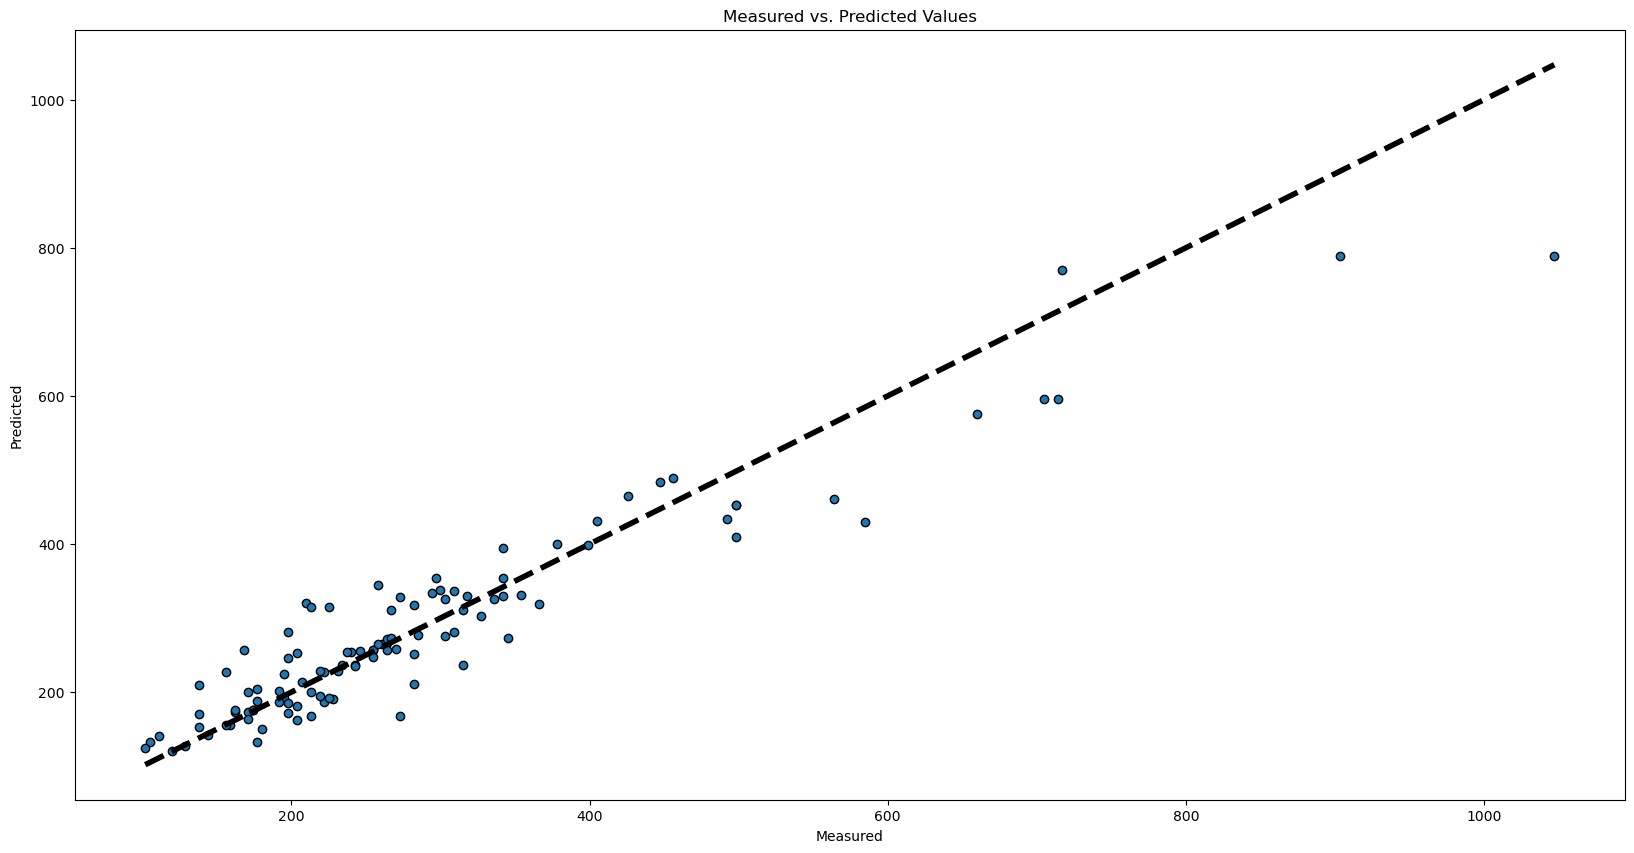

MAE: 36.34378645155165, MSE: 2865.860070588941, R2: 0.8868946419806198, RMSLE: 0.16685554554330953


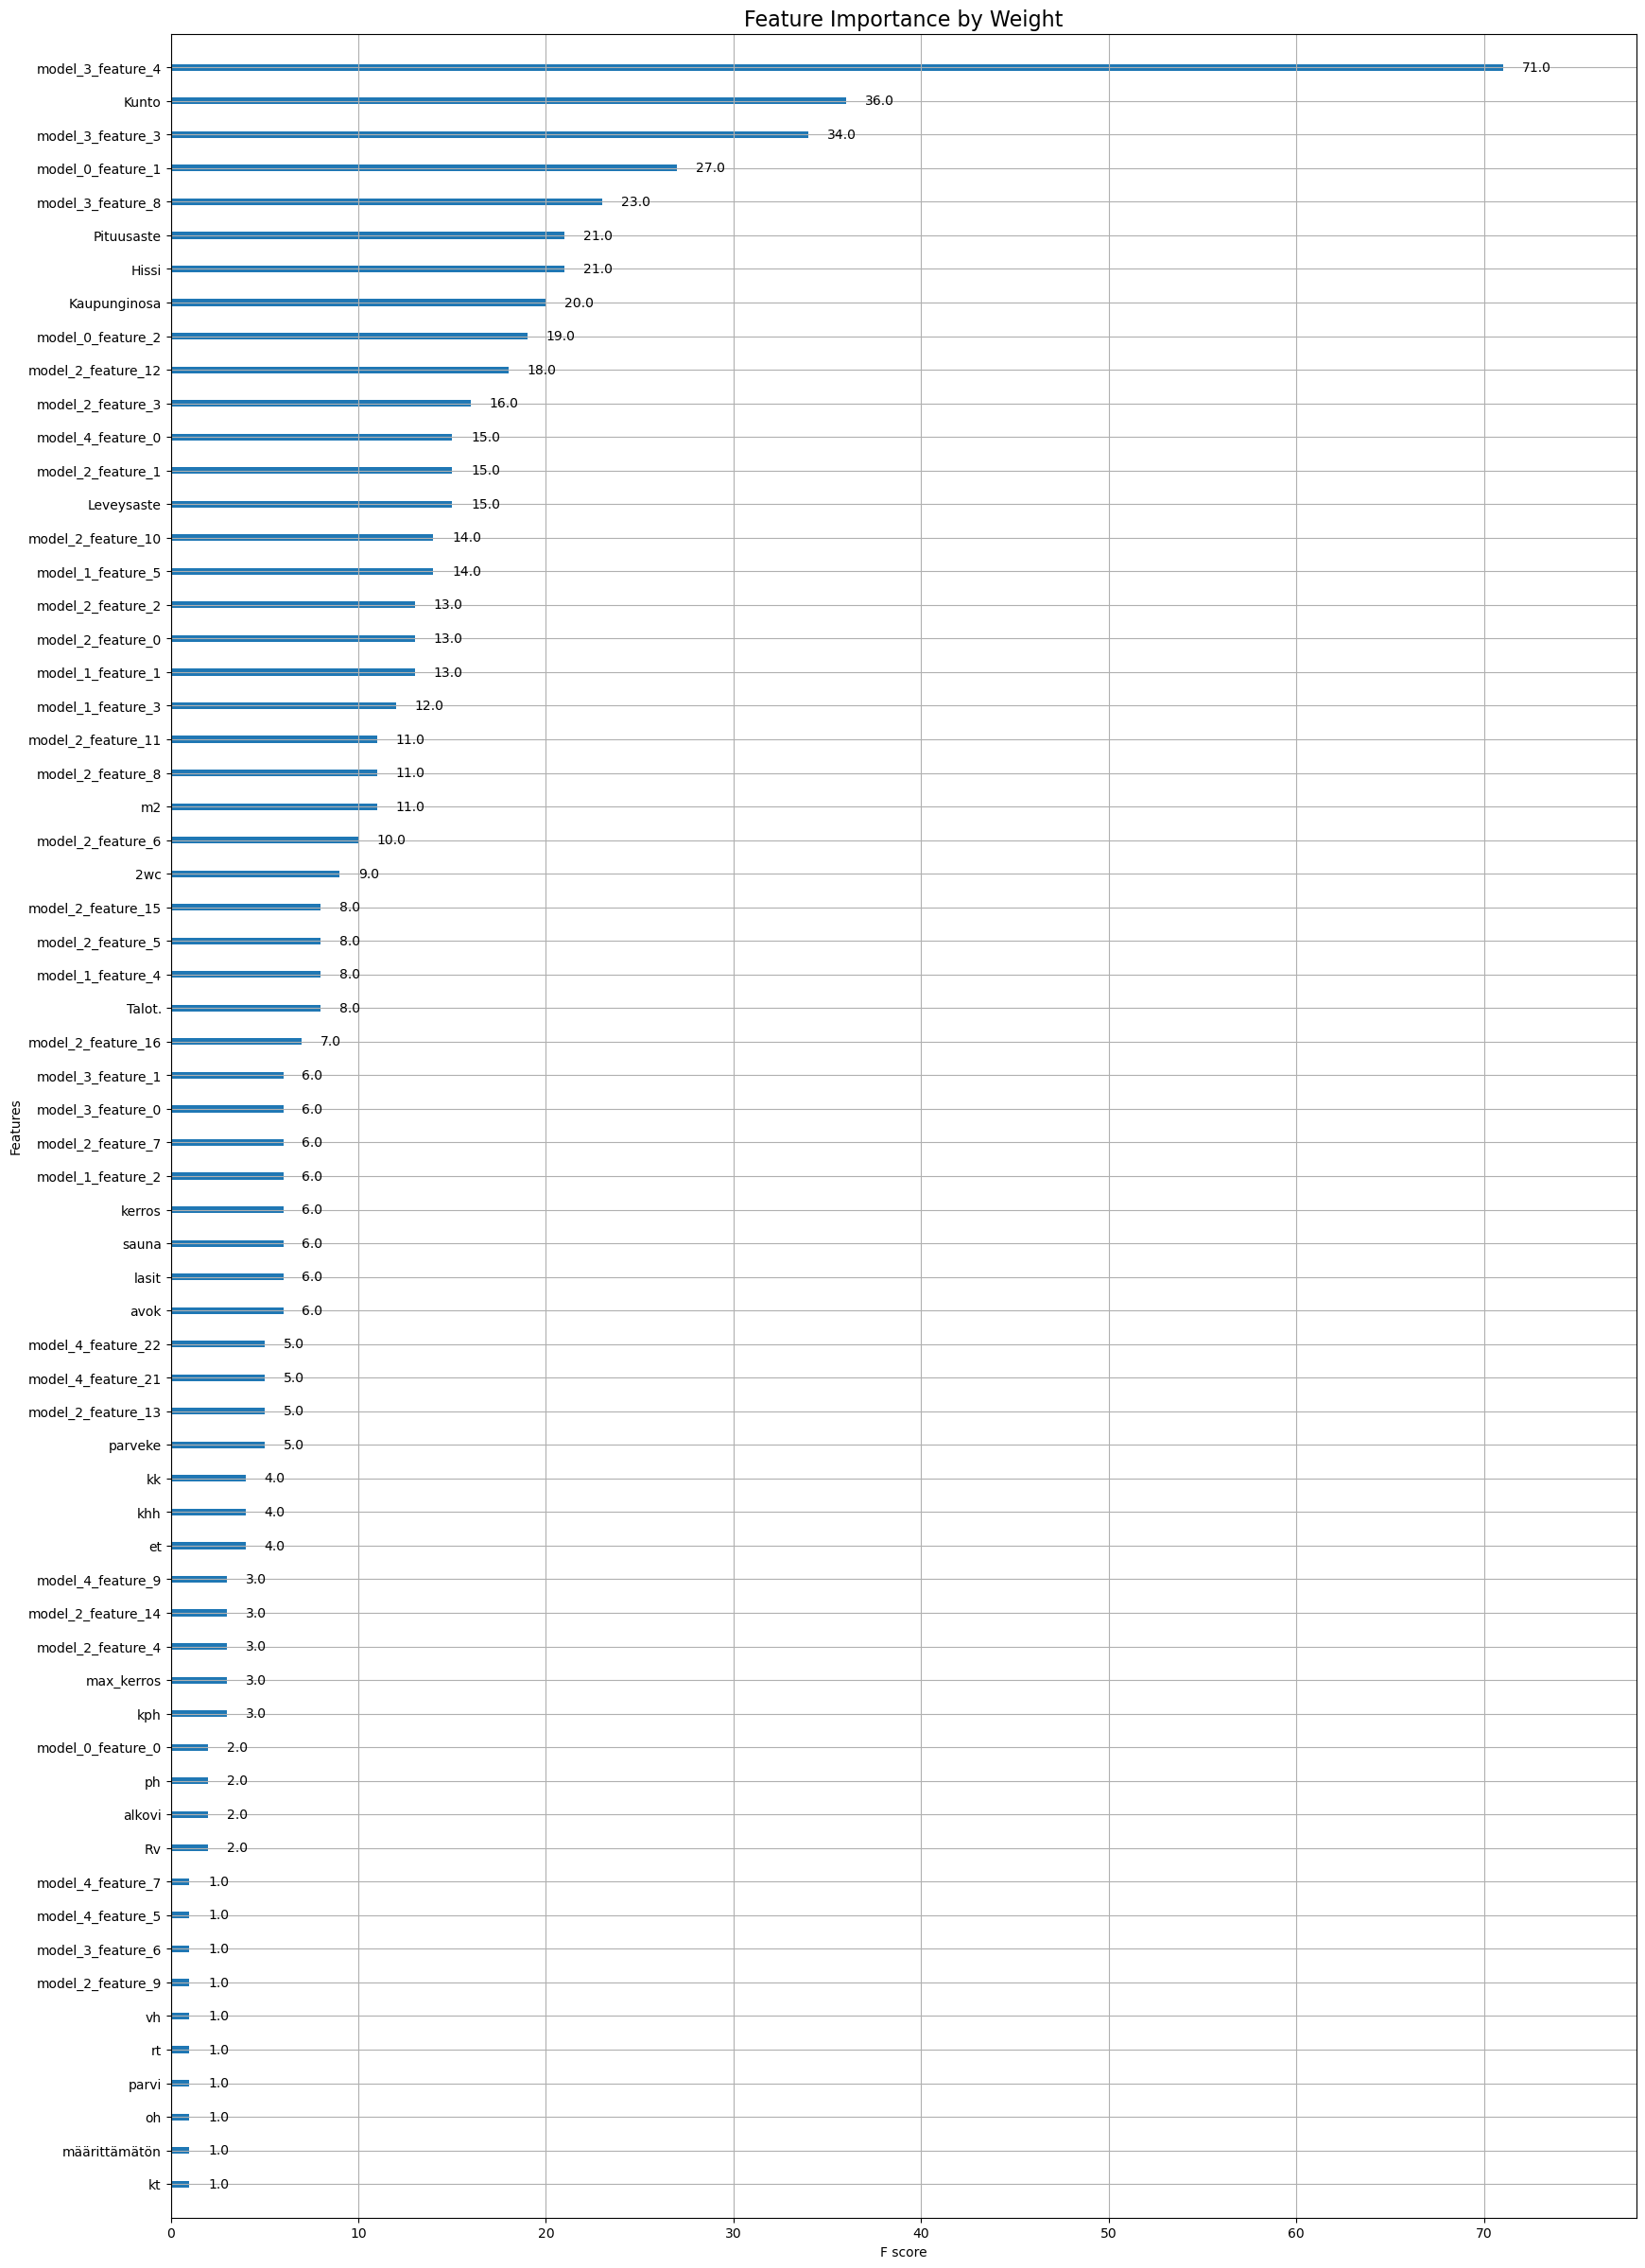

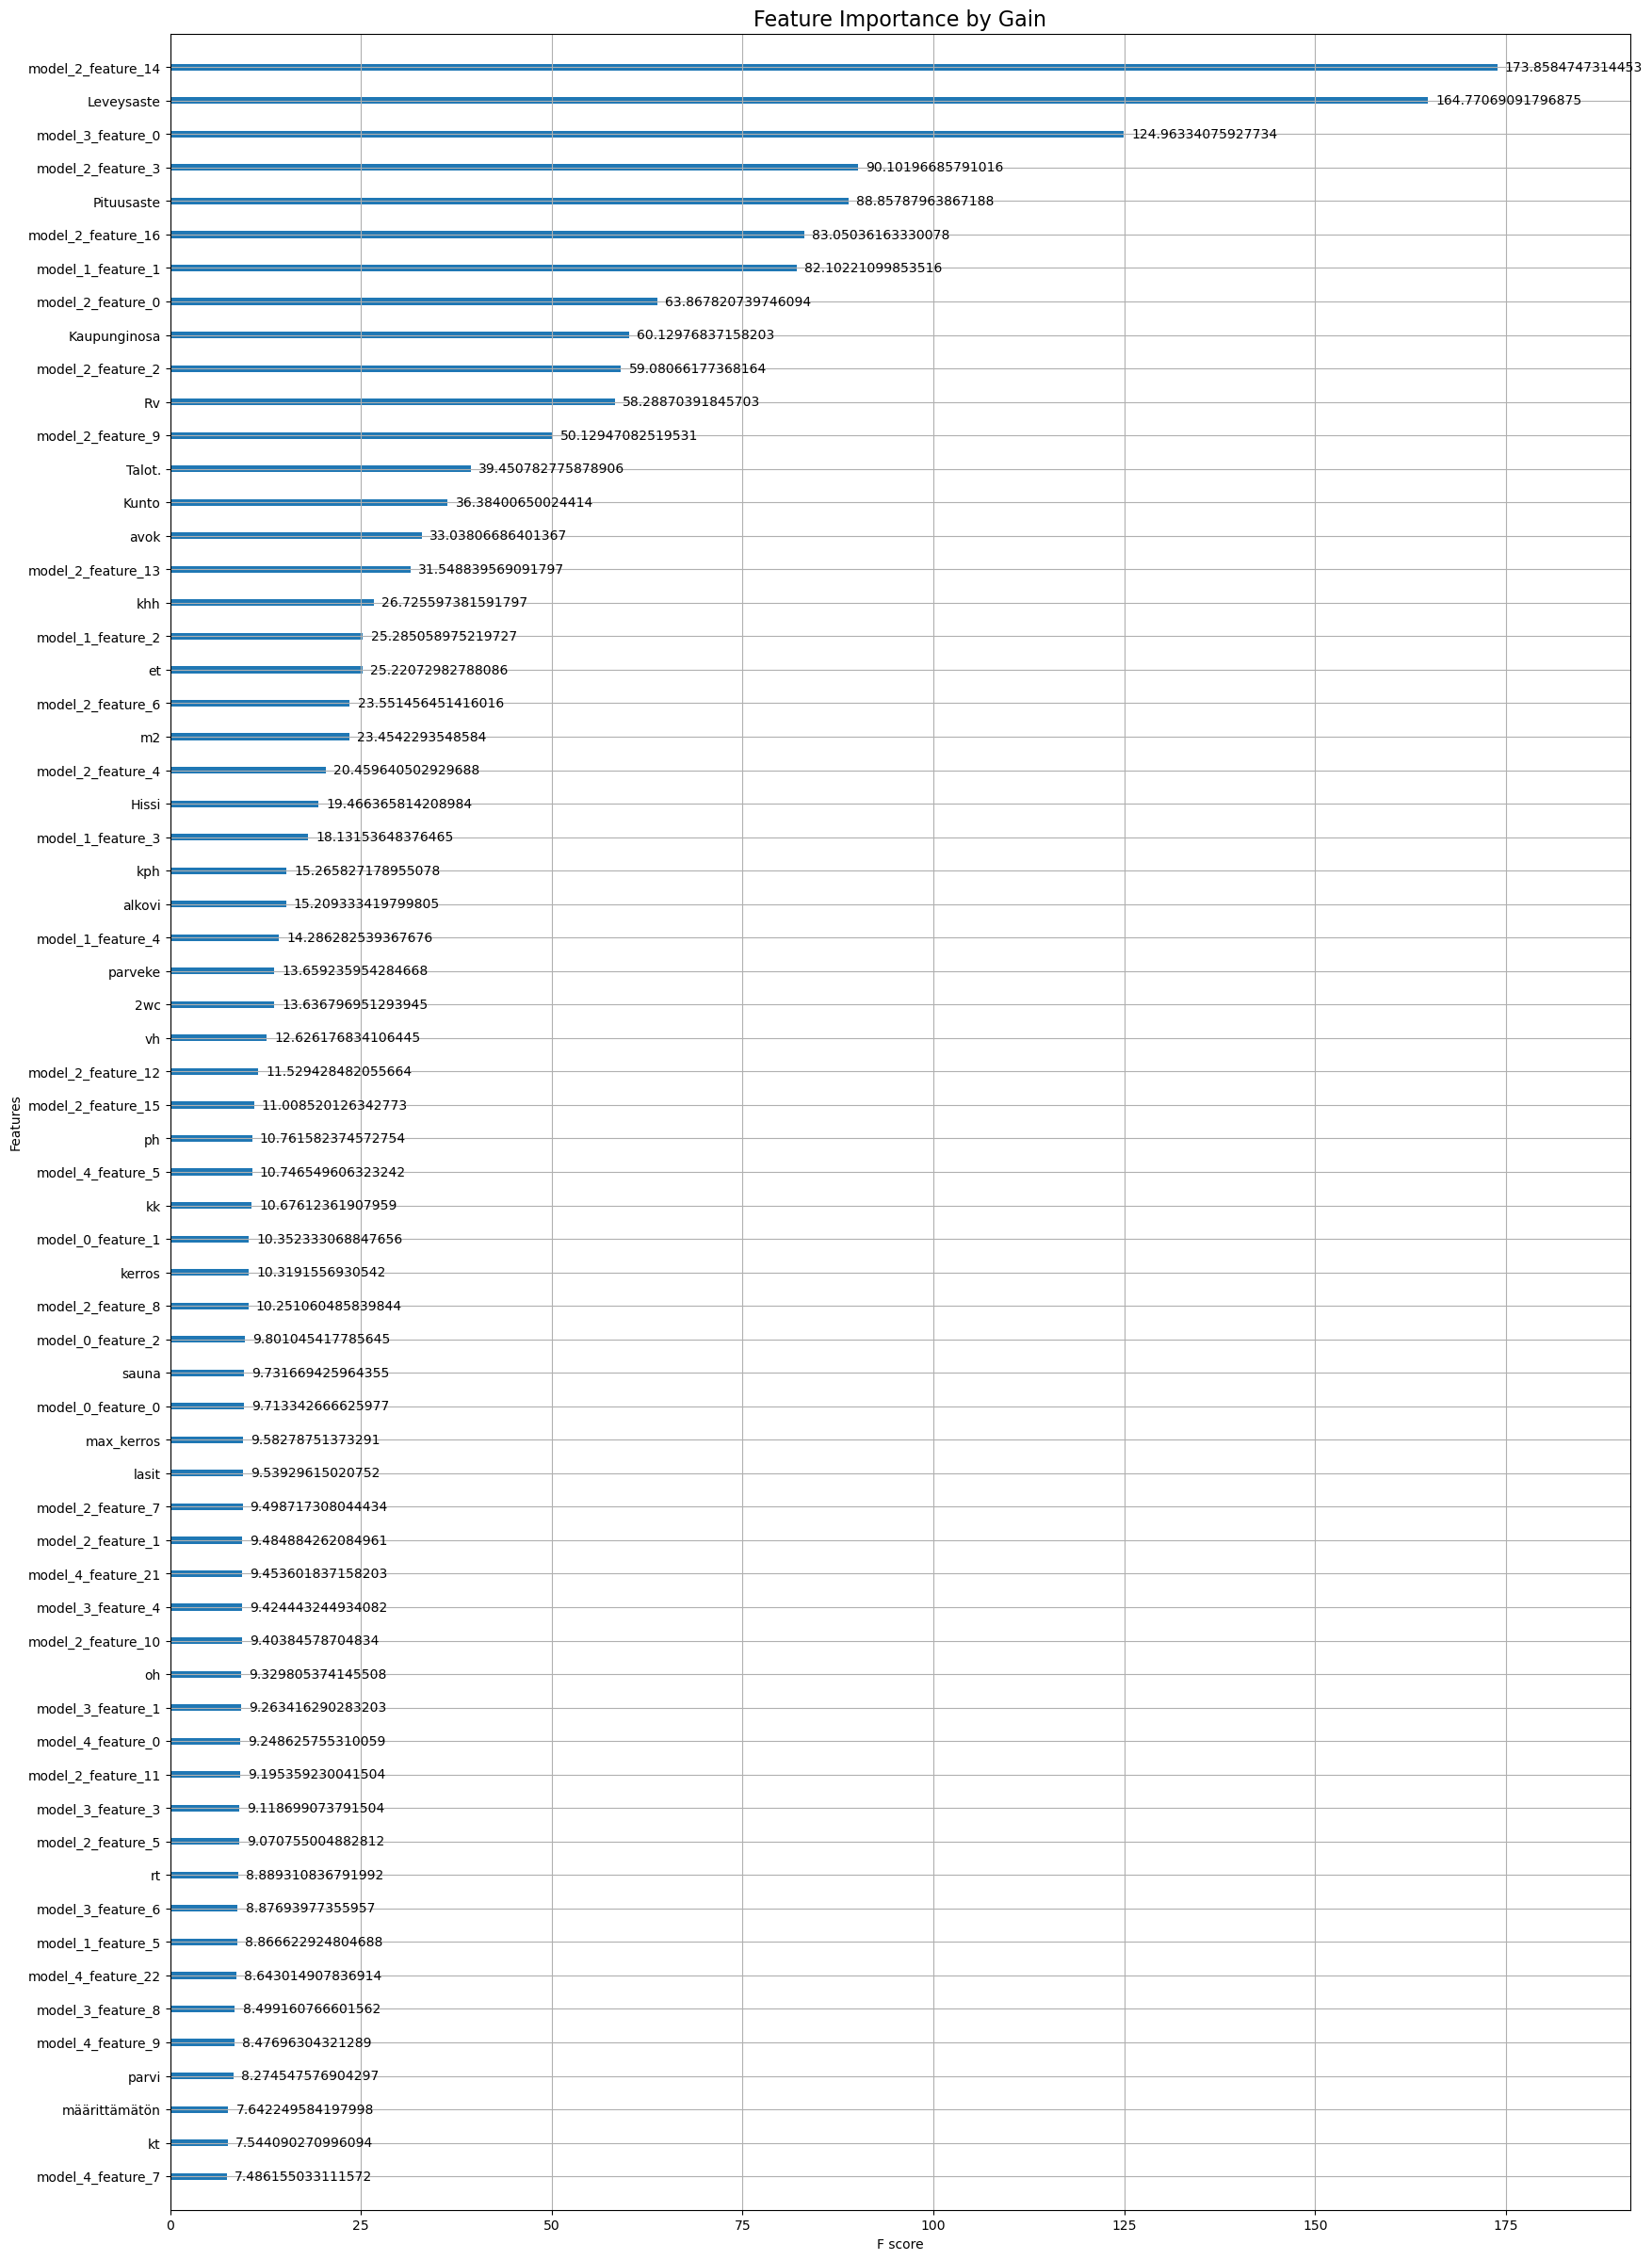

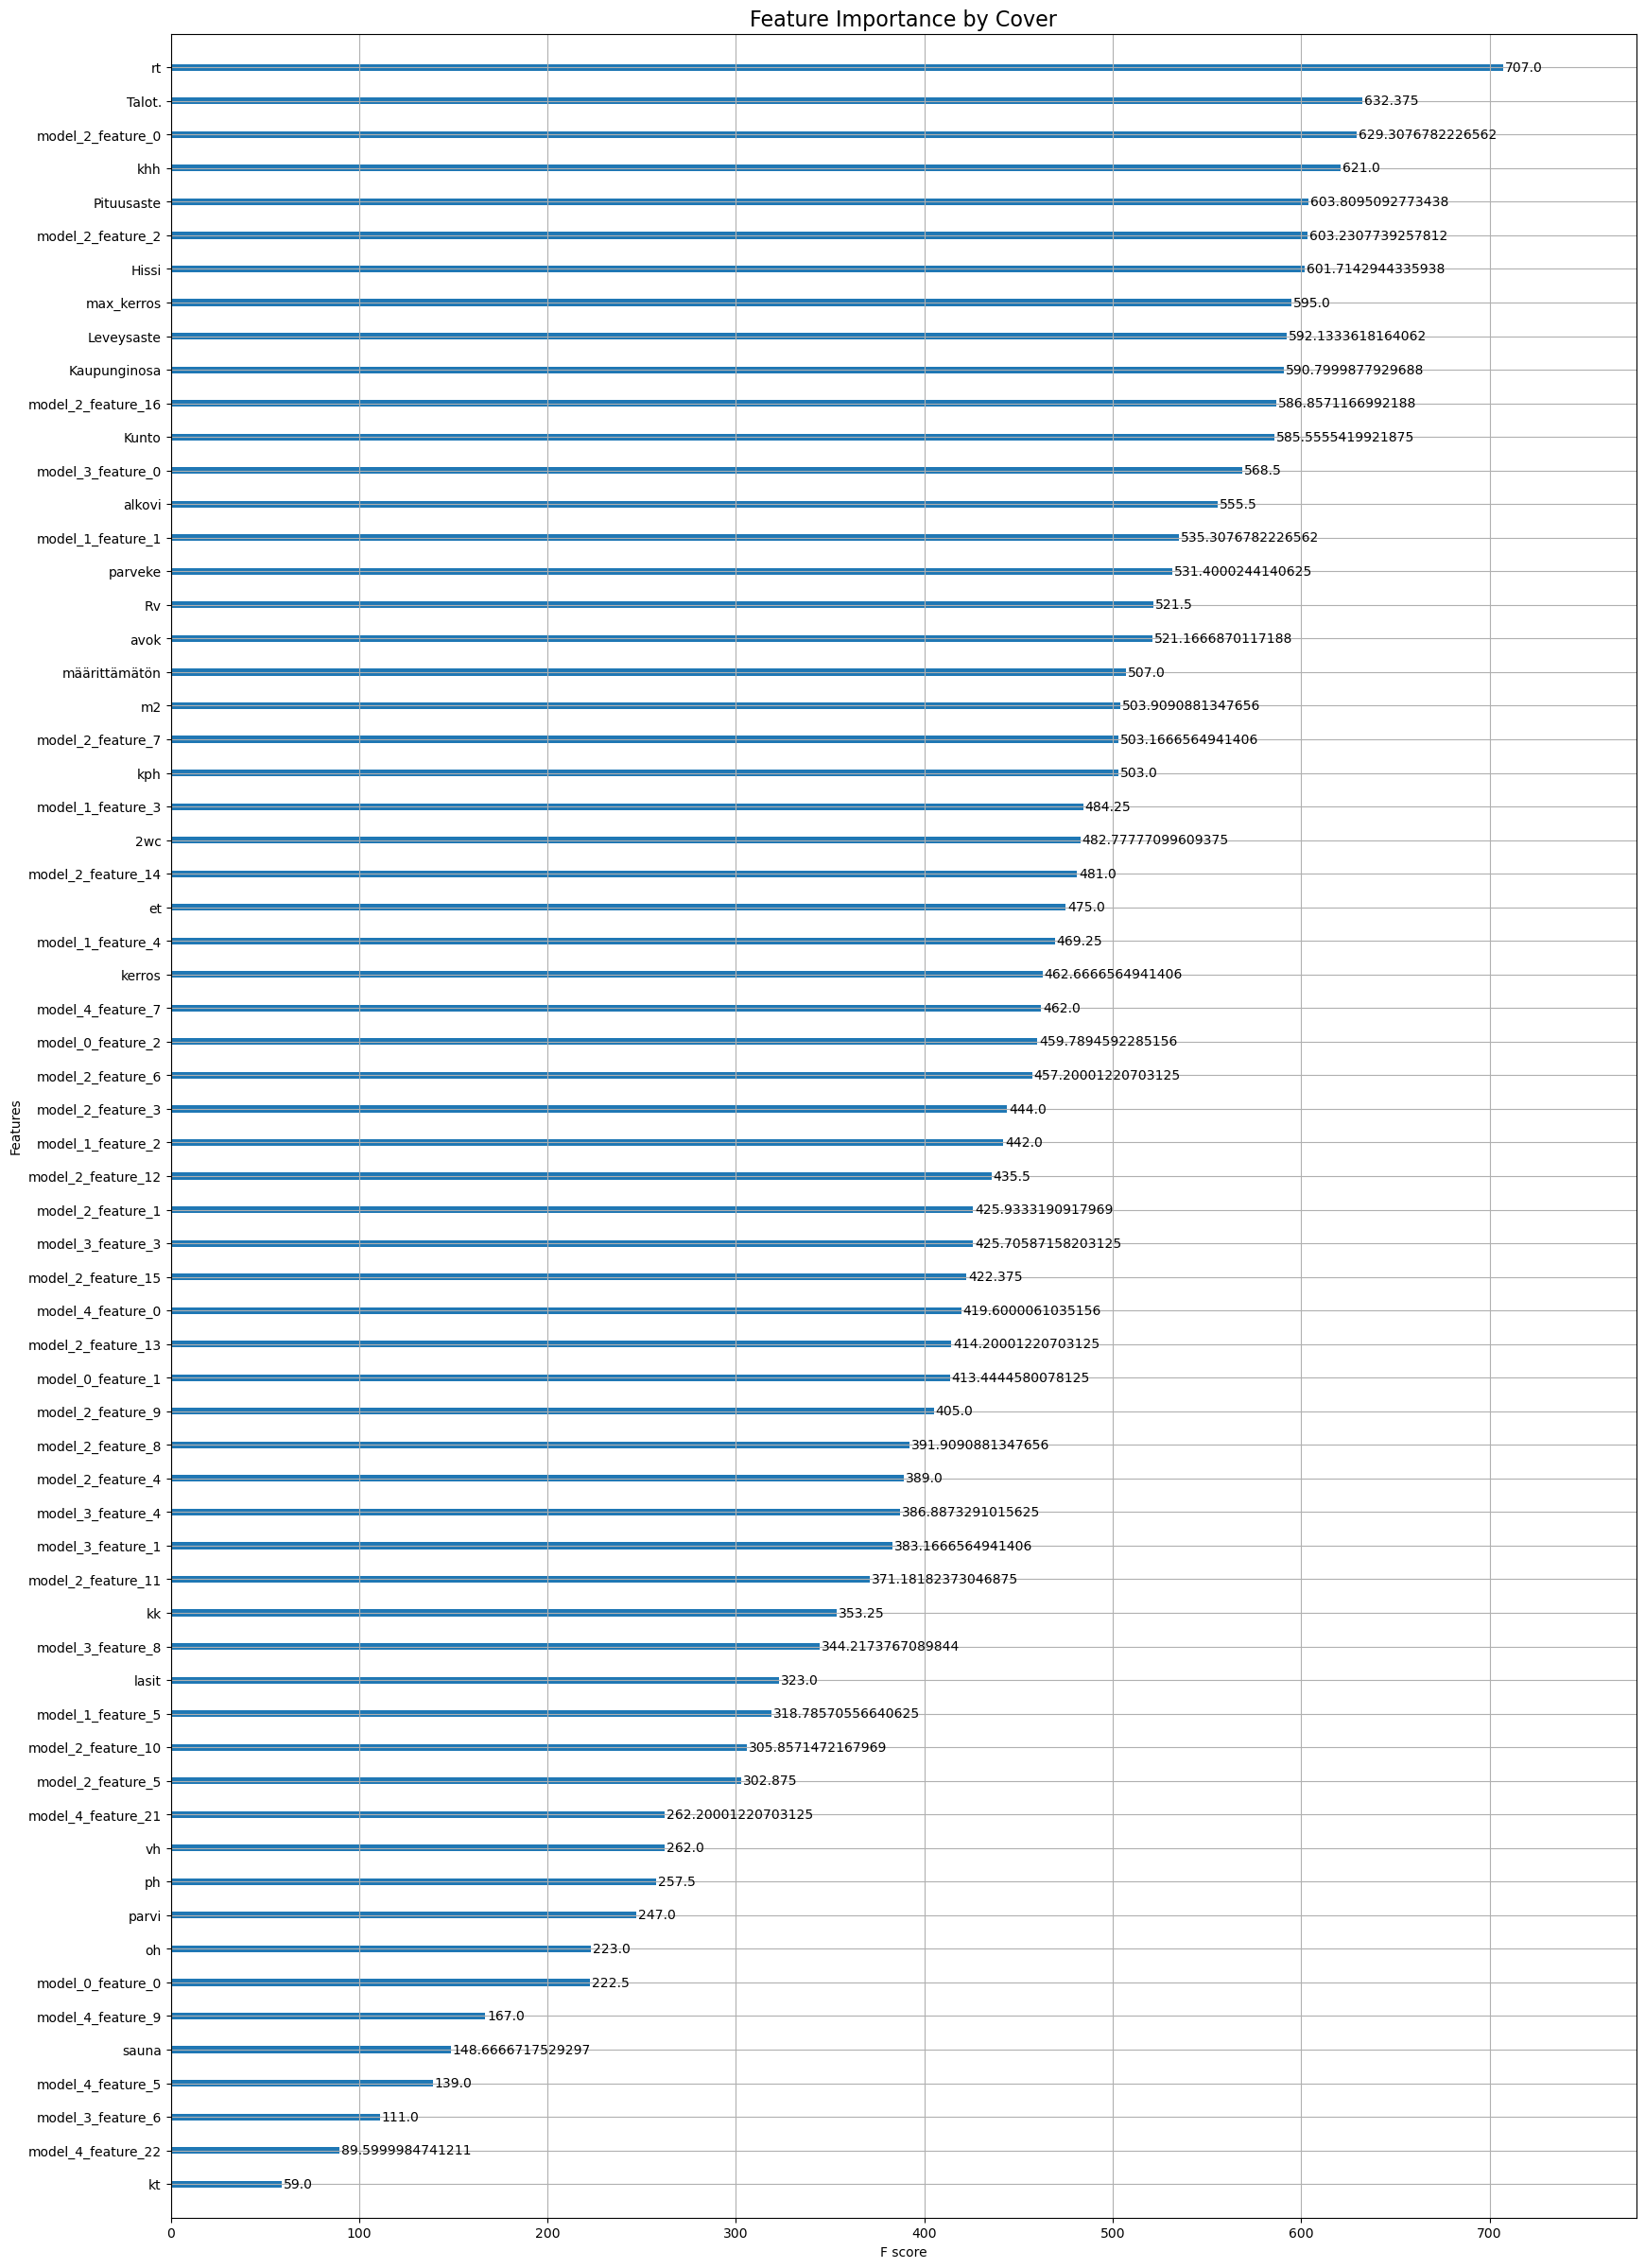

In [78]:
import optuna
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from datetime import timedelta
import time
from tensorflow.keras.models import Model
import glob
import pickle
from tensorflow.keras.models import load_model




time_started_xgb = time.time()

num_of_trials = 720

# Kerätään ensin kaikkien mallien ominaisuusvektorit
X_train_features_list = []
X_test_features_list = []
features_names_list = []

best_optuna_models = []

def rmsle_loss(y_true, y_pred):
    penalty = tf.constant(1e5, dtype=tf.float32)
    valid_mask = tf.math.greater(y_pred, 0.0)
    safe_y_pred = tf.where(valid_mask, y_pred, penalty)
    rmsle = tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(safe_y_pred) - tf.math.log1p(y_true))))
    return tf.where(tf.reduce_any(~valid_mask), penalty, rmsle)

# Kun lataat mallin, määritä mukautettu häviöfunktio custom_objects-parametrissa
custom_objects = {"rmsle_loss": rmsle_loss}

model_best_vals = []

# for fold_num in [1]:
for fold_num in range(folds): # TODO testiä parhailla malleilla
    pattern = f"./NN_search/{study_name}_foldmodel{fold_num}_score_*.h5"  # Oletetaan, että mallit on tallennettu .h5-muodossa
    model_files = glob.glob(pattern)
    
    # Etsi suurin score kunkin foldin mallitiedostoista
    best_score = float('inf')
    best_model_file = None
    for model_file in model_files:
        score_part = model_file.split('_score_')[1]  # Erottaa score osan tiedostonimestä        
        score = float(score_part.split('_')[0])  # Muuttaa scoren float-arvoksi
        if score < best_score:
            best_score = score
            best_model_file = model_file

    model_best_vals.append(best_score)    
    # Lataa parhaan mallin tiedosto
    if best_model_file:
        best_model = load_model(best_model_file, custom_objects=custom_objects)
        best_optuna_models.append(best_model)
        print(f"Loaded best model for fold {fold_num} from {best_model_file} with score {best_score:.4f}")
    else:
        print(f"No model files found for fold {fold_num} matching pattern {pattern}")


# best_models_per_fold-listas

original_feature_names = list(X_train.columns) 

for idx, model in enumerate(best_optuna_models):
    feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    X_train_features = feature_extractor.predict(X_train_NN)
    X_test_features = feature_extractor.predict(X_test_NN)
    
    X_train_features_list.append(X_train_features)
    X_test_features_list.append(X_test_features)

    print(f'Model train feature shape: {X_train_features.shape}')
    print(f'Model test feature shape: {X_test_features.shape}')

    num_features = X_train_features.shape[1]
    model_feature_names = [f"model_{idx}_feature_{feature_idx}" for feature_idx in range(num_features)]
    features_names_list.extend(model_feature_names)

combined_feature_names = original_feature_names + features_names_list

# Yhdistetään ominaisuusvektorit
X_train_combined = np.concatenate(X_train_features_list, axis=1)
X_test_combined = np.concatenate(X_test_features_list, axis=1)

X_train_combined = np.concatenate([X_train_combined, X_train], axis=1)   
X_test_combined = np.concatenate([X_test_combined, X_test], axis=1)

y_train = np.array(y_train)


#### Ei valintaa 
X_train_combined_selected = X_train_combined
X_test_combined_selected = X_test_combined
selected_features_names = combined_feature_names


##### mutual_info_regression Valinta

# from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# max_feature = X_train_combined.shape[1] // 2

# selector = SelectKBest(mutual_info_regression, k=max_feature)

# X_train_combined_selected = selector.fit_transform(X_train_combined, y_train)
# X_test_combined_selected = selector.transform(X_test_combined)

# selected_indices = selector.get_support(indices=True)
# selected_features_names = np.array(combined_feature_names)[selected_indices]
# selected_features_scores = selector.scores_[selected_indices]

# print("Selected features and their scores:")
# for name, score in zip(selected_features_names, selected_features_scores):
#     print(f"{name}: {score}")

# selected_features_names = selected_features_names.tolist()

# print(f'X_train_combined shape: {X_train_combined.shape}')
# print(f'X_train_combined_selected shape: {X_train_combined_selected.shape}')

# print(f'X_test_combined shape: {X_test_combined.shape}')
# print(f'X_test combined selected shape: {X_test_combined_selected.shape}')





# ##### PCA valinta



# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# # Oletetaan, että X_train_combined ja X_test_combined ovat datasi
# # Ja combined_feature_names on alkuperäisten featureiden nimilista

# # Skaalataan data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_combined)
# X_test_scaled = scaler.transform(X_test_combined)

# # Sovellamme PCA:ta
# pca = PCA(n_components=0.85) # tai voit määrittää n_components arvon eksplisiittisesti
# X_train_combined_selected = pca.fit_transform(X_train_scaled)
# X_test_combined_selected = pca.transform(X_test_scaled)

# # Luodaan uudet feature-nimet pääkomponenteille
# selected_features_names = [f"PC{i+1}" for i in range(X_train_combined_selected.shape[1])]

# print(f"Alkuperäinen featureiden määrä: {X_train_combined.shape[1]}")
# print(f"Featureiden määrä PCA:n jälkeen: {X_train_combined_selected.shape[1]}")

# # Nyt sinulla on X_train_pca ja X_test_pca datat sekä niiden vastaavat feature-nimet
# # Voit jatkaa näiden käyttämistä mallisi koulutukseen



#####

def rmsle(y_true, y_pred):
    if np.any(y_pred <= 0):
        return 1e6
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))
from sklearn.model_selection import KFold



max_feature = X_train_combined.shape[1]

def objective(trial):
    # Määritetään parametrit, jotka optimoidaan
    param = {
        'tree_method': 'hist',          
        'objective': trial.suggest_categorical('objective', ['reg:squarederror', 'reg:absoluteerror']),        
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10)        
    }
    num_boost_round = trial.suggest_int('num_boost_round', 10, 142)

    # K-fold cross-validation
    kf = KFold(n_splits=5)
    rmsle_scores = []
  
    for train_index, val_index in kf.split(X_train_combined_selected):
        X_train_k, X_val_k = X_train_combined_selected[train_index], X_train_combined_selected[val_index]
        y_train_k, y_val_k = y_train[train_index], y_train[val_index]

        dtrain = xgb.DMatrix(X_train_k, label=y_train_k, feature_names=selected_features_names)
        dval = xgb.DMatrix(X_val_k, label=y_val_k, feature_names=selected_features_names)

        evals_result = {}
        bst = xgb.train(param, dtrain, num_boost_round=num_boost_round, evals=[(dval, 'val')], evals_result=evals_result, verbose_eval=False, early_stopping_rounds=300)
        # Käytä paras iteraatio määrä laskemaan ennusteet ja RMSLE
        best_iteration = bst.best_iteration
        preds = bst.predict(dval, iteration_range=(0, best_iteration + 1))
        loss = rmsle(y_val_k, preds)
        rmsle_scores.append(loss)

    average_rmsle = np.mean(rmsle_scores)
    return average_rmsle

# study = optuna.create_study(direction='minimize', 
#                             storage='sqlite:///tampere_reg.db', 
#                             study_name='xgb_combined_selection_2503', # TODO muuta nimeä tarvittaessa
#                             load_if_exists=False) 

study = optuna.create_study(direction='minimize')

# study.sampler = optuna.samplers.RandomSampler()
study.sampler = optuna.samplers.QMCSampler(warn_independent_sampling = False)
print(f'Random sampling {num_of_trials} trials...')
study.optimize(objective, n_trials=num_of_trials)
study.sampler = optuna.samplers.TPESampler()
print(f'TPE sampling {num_of_trials} trials...')
study.optimize(objective, n_trials=num_of_trials)


print(f'Time taken for XGBoost optimization: {str(timedelta(seconds=(time.time() - time_started_xgb)))}')
print(f'Time taken for one trial: {str(timedelta(seconds=(time.time() - time_started_xgb) / (num_of_trials*2)))}')


# Parhaiden parametrien tulostus ja mallin koulutus
print(f"Best val: {study.best_trial.value}")
print(f'Best params: {study.best_params}')

dtrain = xgb.DMatrix(X_train_combined_selected, label=y_train, feature_names=selected_features_names)
best_model = xgb.train(best_params, dtrain, num_boost_round=best_params['num_boost_round'])

# Ennustukset ja evaluointi testidatalla
dtest = xgb.DMatrix(X_test_combined_selected, label=y_test, feature_names=selected_features_names)
predictions = best_model.predict(dtest)

# Visualisoidaan ennustettuja arvoja verrattuna todellisiin arvoihin
plt.figure(figsize=(20, 10))
plt.scatter(y_test, predictions, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs. Predicted Values')
plt.show()

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmsle_val = rmsle(y_test, predictions)
print(f"MAE: {mae}, MSE: {mse}, R2: {r2}, RMSLE: {rmsle_val}")

fig, ax = plt.subplots(figsize=(20, 30))
xgb.plot_importance(best_model, importance_type='weight', ax=ax)
ax.set_title('Feature Importance by Weight', fontsize=16)
plt.show()

# Asetetaan toisen kuvaajan koko
fig, ax = plt.subplots(figsize=(20, 30))
xgb.plot_importance(best_model, importance_type='gain', ax=ax)
ax.set_title('Feature Importance by Gain', fontsize=16)
plt.show()

# Asetetaan kolmannen kuvaajan koko
fig, ax = plt.subplots(figsize=(20, 30))
xgb.plot_importance(best_model, importance_type='cover', ax=ax)
ax.set_title('Feature Importance by Cover', fontsize=16)
plt.show()




In [66]:
predictions_train = []

for idx, model in enumerate(best_optuna_models):
    pred = model.predict(X_train_NN, verbose=0).flatten()
    predictions_train.append(pred)

predictions_test = []

for idx, model in enumerate(best_optuna_models):
    pred = model.predict(X_test_NN, verbose=0).flatten()
    predictions_test.append(pred)


print('Keskiarvo ')
predictions_mean = np.mean(predictions_test, axis=0)
mse = mean_squared_error(y_test, predictions_mean)
mae = mean_absolute_error(y_test, predictions_mean)
r2 = r2_score(y_test, predictions_mean)
rmsle_val = rmsle(y_test, predictions_mean)  # Oletetaan että sinulla on rmsle funktio määritelty
print(f"MAE: {mae}, MSE: {mse}, R2: {r2}, RMSLE: {rmsle_val}\n\n")

print('Painotettu keskiarvo käänteisillä')
total = sum(model_best_vals)
weights = [x / total for x in model_best_vals]
weighted_predictions = np.average(predictions_test, axis=0, weights=weights)
mse = mean_squared_error(y_test, weighted_predictions)
mae = mean_absolute_error(y_test, weighted_predictions)
r2 = r2_score(y_test, weighted_predictions)
rmsle_val = rmsle(y_test, weighted_predictions)  # Oletetaan että sinulla on rmsle funktio määritelty
print(f"MAE: {mae}, MSE: {mse}, R2: {r2}, RMSLE: {rmsle_val}\n\n")


from sklearn.linear_model import LinearRegression

# Oletetaan, että `predictions` on lista, joka sisältää kunkin mallin ennusteet testidatasetille
X_meta_train = np.stack(predictions_train, axis=1)
X_meta_test = np.stack(predictions_test, axis=1)
# Koulutetaan meta-malli
meta_model = LinearRegression()
meta_model.fit(X_meta_train, y_train)

# Käytetään meta-mallia ennustamaan
linear_predictions = meta_model.predict(X_meta_test)

print('Linear meta')
mse = mean_squared_error(y_test, linear_predictions)
mae = mean_absolute_error(y_test, linear_predictions)
r2 = r2_score(y_test, linear_predictions)
rmsle_val = rmsle(y_test, linear_predictions)  # Oletetaan että sinulla on rmsle funktio määritelty
print(f"MAE: {mae}, MSE: {mse}, R2: {r2}, RMSLE: {rmsle_val}\n\n")



from sklearn.svm import SVR

print('SVM')
X_train_svm = np.column_stack(predictions_train)
X_test_svm = np.column_stack(predictions_test)

svm_regressor = SVR(kernel='linear')
svm_regressor.fit(X_train_svm, y_train)

# Käytetään opetettua SVM-regressoria ennustamaan testidatan "oikeat" arvot
predictions_svm = svm_regressor.predict(X_test_svm)

# Arvioidaan mallin suorituskykyä
mse = mean_squared_error(y_test, predictions_svm)
mae = mean_absolute_error(y_test, predictions_svm)
r2 = r2_score(y_test, predictions_svm)
rmsle_val = rmsle(y_test, predictions_svm)
print(f"SVM MAE: {mae}, MSE: {mse}, R2: {r2}, RMSLE: {rmsle_val}\n\n")



Keskiarvo 
MAE: 42.41549301147461, MSE: 4962.847509001151, R2: 0.8041339666015828, RMSLE: 0.18093006238110587


Painotettu keskiarvo käänteisillä
MAE: 42.582109219817006, MSE: 5046.322512635517, R2: 0.8008395035297016, RMSLE: 0.1814830253627674


Linear meta
MAE: 39.20396055998626, MSE: 2953.4962026668472, R2: 0.8834359538904969, RMSLE: 0.19330234567020235


SVM
SVM MAE: 39.33455224531535, MSE: 3561.421025569556, R2: 0.8594433118739071, RMSLE: 0.18848034687215184


